<a href="https://colab.research.google.com/github/moeenessa31-lgtm/Project/blob/main/Fork_of_DS_Task_B_HE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
psparks_instacart_market_basket_analysis_path = kagglehub.dataset_download('psparks/instacart-market-basket-analysis')

print('Data source import complete.')


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
psparks_instacart_market_basket_analysis_path = kagglehub.dataset_download('psparks/instacart-market-basket-analysis')

print('Data source import complete.')


Data source import complete.


# ***Welcome To The Machine Learning (1) Project***

***What we are trying to do in this project is to apply everything we learned in the machine learning course, from analyzing, cleaning, and processing data to applying machine learning algorithms.***

## And of course, we will use this dataset [**Dataset**](https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis) to practice sorcery on it.


## ***We will do our best to carry out all the required tasks..***

## **The students in charge of this project:**
- ***Hamza Moeen Rasheed Issa***
- ***Zaid Yusef GH. Hashash***



---






---




- In the first cell, we will import the libraries used in the project.

In [ ]:
import pandas as pd
import numpy as np
import os
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import xgboost as xgb
import gc
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, precision_score

- Download data directly from Kaggle, via **API Token**

  -**(google.colab files)**
  This is the library used to upload API tokens

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/products.csv
/kaggle/input/order_products__train.csv
/kaggle/input/orders.csv
/kaggle/input/order_products__prior.csv
/kaggle/input/aisles.csv
/kaggle/input/departments.csv


In [ ]:
Types = {
    'aisle_id': 'int32',
    'aisle': 'category',
    'order_id': 'int32',
    'user_id': 'int32',
    'eval_set': 'category',
    'order_number': 'int32',
    'order_dow': 'int32',
    'order_hour_of_day': 'int32',
    'days_since_prior_order': 'float16',
    'department_id': 'int8',
    'department': 'category',
    'product_id': 'int32',
    'product_name': 'category',
    'add_to_cart_order': 'int32',
    'reordered': 'int8',
}


# Reading files using enhanced data types
aisles = pd.read_csv('/kaggle/input/aisles.csv', dtype={i: Types.get(i, None) for i in ['aisle_id','aisle']})

departments = pd.read_csv('/kaggle/input/departments.csv', dtype={i: Types.get(i, None) for i in ['department_id','department']})

products = pd.read_csv('/kaggle/input/products.csv', dtype={i: Types.get(i, None) for i in ['product_id', 'aisle_id', 'department_id',' product_name']})

# Read orders, excluding 'days_since_prior_order' from explicit dtype setting during read_csv
orders = pd.read_csv('/kaggle/input/orders.csv', dtype={i: Types.get(i, None) for i in ['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day','eval_set']})
# Convert 'days_since_prior_order' to float16 after loading the DataFrame
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype('float16')

order_products_prior = pd.read_csv('/kaggle/input/order_products__prior.csv', dtype={i: Types.get(i, None) for i in ['order_id', 'product_id', 'add_to_cart_order', 'reordered']})


In [ ]:
print(aisles.info())
print("------------------------------------------------")
print(orders.info())
print("------------------------------------------------")
print(departments.info())
print("------------------------------------------------")
print(products.info())
print("------------------------------------------------")
print(order_products_prior.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   aisle_id  134 non-null    int32   
 1   aisle     134 non-null    category
dtypes: category(1), int32(1)
memory usage: 6.0 KB
None
------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   user_id                 int32   
 2   eval_set                category
 3   order_number            int32   
 4   order_dow               int32   
 5   order_hour_of_day       int32   
 6   days_since_prior_order  float16 
dtypes: category(1), float16(1), int32(5)
memory usage: 75.0 MB
None
------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entrie

In [ ]:
My_Data = pd.merge(orders, order_products_prior,how = 'left', on='order_id')


My_Data = pd.merge(My_Data, products,how = 'left', on='product_id')


My_Data = pd.merge(My_Data, aisles,how = 'left', on='aisle_id')


My_Data = pd.merge(My_Data, departments,how = 'left', on='department_id')


My_Data.head()

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0,Soda,77.0,7.0,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0,Organic Unsweetened Vanilla Almond Milk,91.0,16.0,soy lactosefree,dairy eggs
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0,Original Beef Jerky,23.0,19.0,popcorn jerky,snacks
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0,Aged White Cheddar Popcorn,23.0,19.0,popcorn jerky,snacks
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0,XL Pick-A-Size Paper Towel Rolls,54.0,17.0,paper goods,household


In [ ]:
My_Data['product_name'] = My_Data['product_name'].astype('category')

In [ ]:
print(My_Data.shape)
print("-----------------------------")
print(My_Data.info())

(32640698, 15)
-----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32640698 entries, 0 to 32640697
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   user_id                 int32   
 2   eval_set                category
 3   order_number            int32   
 4   order_dow               int32   
 5   order_hour_of_day       int32   
 6   days_since_prior_order  float16 
 7   product_id              float64 
 8   add_to_cart_order       float64 
 9   reordered               float64 
 10  product_name            category
 11  aisle_id                float64 
 12  department_id           float64 
 13  aisle                   category
 14  department              category
dtypes: category(4), float16(1), float64(5), int32(5)
memory usage: 2.1 GB
None


# **• Missing value analysis and visualization**

In [ ]:
# missing_data = My_Data.isnull().sum()
# print(missing_data)

# print("-------------------------------")
# missing_percentage = (My_Data.isnull().sum() / len(My_Data)) * 100
# print(missing_percentage)

In [ ]:
# missing_percentage = missing_percentage[missing_percentage > 0]

# if not missing_percentage.empty:
#     missing_percentage.sort_values().plot(kind='barh', figsize=(10, 6), color='skyblue')
#     plt.title('Percentage of Missing Values in Dataset')
#     plt.xlabel('Percentage (%)')
#     plt.show()
#     plt.close()

# else:
#   print("There are not missing values")

## **We will process missing values ​​directly to reduce memory usage.**

-  ***Since these are missing values ​​due to the lack of matching records in other tables, we will use a fixed-value compensation method.***

In [ ]:
# Text column processing
for col in ['product_name', 'aisle', 'department']:
    if My_Data[col].dtype.name == 'category' and 'Unknown' not in My_Data[col].cat.categories:
        My_Data[col] = My_Data[col].cat.add_categories(['Unknown'])
    My_Data[col] = My_Data[col].fillna('Unknown')

# Processing numerical columns
for col in ['product_id', 'aisle_id', 'department_id', 'add_to_cart_order', 'reordered']:
    My_Data[col] = My_Data[col].fillna(-1).astype('int32')

-  Now, let's address the missing values ​​from the column (days_since_prior_order)

In [ ]:
My_Data['days_since_prior_order'] = My_Data['days_since_prior_order'].fillna(-1)

In [ ]:
# missing_data = My_Data.isnull().sum()
# print(missing_data)

# print("-------------------------------")
# missing_percentage = (My_Data.isnull().sum() / len(My_Data)) * 100
# print(missing_percentage)



---


# **• Distribution plots for numeric features and target(s) (histogram, density).**

### ***-  These six columns were chosen because they encompass the three fundamental dimensions of any recommendation system: time (hour and day of order), behavior (number of orders and basket order), and periodicity (days since the last order). These columns are the most correlated with the target variable (reordered).***

-   **Determine peak activity**

     The diagram shows that activity starts to rise from 7 am and reaches its peak between 10 am and 4 pm.

In [ ]:
# hourly_dist = My_Data['order_hour_of_day'].value_counts().sort_index()

# plt.figure(figsize=(10, 5))
# sns.barplot(x=hourly_dist.index, y=hourly_dist.values, color='teal')
# plt.title('Distribution of Orders by Hour of Day')
# plt.xlabel('Hour of Day')
# plt.ylabel('Total Orders')
# plt.show()
# plt.close()

# del hourly_dist
# gc.collect()

-  **Distribution of days of the week**

    The distribution of orders across the days of the week (from 0 to 6) shows that Saturday and Sunday are the most active days.

In [ ]:
# dow_dist = My_Data['order_dow'].value_counts().sort_index()

# plt.figure(figsize=(8, 4))
# sns.barplot(x=dow_dist.index, y=dow_dist.values, palette='viridis')
# plt.title('Distribution of Orders by Day of Week')
# plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Sat','Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
# plt.show()
# plt.close()

# del dow_dist
# gc.collect()

-  Distribution of days since the last request

    This graph (Density Plot) shows when customers will return to buy again. We notice two clear peaks; one at 7 days and another very sharp one at 30 days.

In [ ]:
# sample_data = My_Data['days_since_prior_order'].dropna().sample(2000000)

# plt.figure(figsize=(10, 5))
# sns.kdeplot(sample_data, fill=True, color="r")
# plt.title('Density Plot: Days Since Prior Order')
# plt.show()
# plt.close()

-  **Order of adding products to the cart**

    The probability of a product being the first, second, or tenth item in the shopping cart is shown; the vast majority of products are added to the first five positions (1 to 5), and the higher the position, the fewer the number.

    - Because the dataset exceeds 32 million records, plotting the Key Density Curve (KDE) requires immense processing power. I used a random sample of 2 million records to ensure accurate representation of the statistical distribution while maintaining performance efficiency and processing speed.

    - The value (-1) was used as the Sentinel Value to represent initial requests that contained missing values. Having this value appear separately in the Distribution Plot ensures that new user data is not mixed with that of repeat users, and prevents the model from being biased towards average values ​​such as 7 or 8 days.

In [ ]:
# cart_dist = My_Data['add_to_cart_order'].value_counts().head(50)

# plt.figure(figsize=(12, 5))
# sns.barplot(x=cart_dist.index, y=cart_dist.values, color='salmon')
# plt.title('Distribution of Add-to-Cart Order (Top 50)')
# plt.xlabel('Order in Cart')
# plt.ylabel('Count')
# plt.show()
# plt.close()

# del cart_dist
# gc.collect()

-  **Customer loyalty**

    The distribution of the number of requests per user is shown. The distribution is right-skewed, as most users have a small number of requests, while the number gradually decreases for "loyal" users who have requested more than 50 times.

In [ ]:
# plt.figure(figsize=(10, 5))
# plt.hist(My_Data['order_number'], bins=50, color='skyblue', edgecolor='black')
# plt.title('Distribution of Order Number (Customer Loyalty)')
# plt.xlabel('Order Number')
# plt.ylabel('Frequency')
# plt.show()
# plt.close()

-  **Target variable**

    The graph shows the ratio of products that are repurchased versus those that are purchased for the first time.

# **• Categorical cardinality analysis (barplots / top-k frequencies)**

-  We focused on analyzing aisles and sections because they represent structural levels of data. Analyzing them allows us to understand the distribution of purchasing power and identify the categories that dominate transaction volume, which helps simplify the model's feature engineering and ensures its ability to differentiate between fast-moving consumer goods and seasonal goods.

-  **Focus on the most impactful corridors**

    Analysis of all aisles reveals that the Fresh Fruits aisle leads the list with exceptional purchasing volume. This indicates that repurchase decisions in this project are directly influenced by perishable goods, justifying the focus on short-term (7-day) order fulfillment patterns.

In [ ]:
# top_aisles = My_Data['aisle'].value_counts()

# plt.figure(figsize=(15, 30))

# sns.barplot(
#     x=top_aisles.values,
#     y=top_aisles.index,
#     order=top_aisles.index,
#     palette='magma'
# )

# plt.title('Top Frequent Aisles (Sorted from High to Low)')
# plt.xlabel('Count of Items')
# plt.ylabel('Aisle Name')
# plt.show()
# plt.close()

- We moved from detailed aisle analysis to departmental analysis to gain a comprehensive strategic perspective. The results showed that the Produce department represented the largest weight in the data, reinforcing our hypothesis that repurchase behavior is closely linked to fresh, everyday produce.

In [ ]:
# dept_counts = My_Data['department'].value_counts()

# plt.figure(figsize=(12, 8))
# sns.barplot(
#     x=dept_counts.values,
#     y=dept_counts.index,
#     order=dept_counts.index,
#     palette='viridis'
# )

# plt.title('Frequency of Items by Department (Sorted)')
# plt.xlabel('Count of Items')
# plt.ylabel('Department Name')
# plt.show()
# plt.close()

# del dept_counts
# gc.collect()

-  I performed a **categorical cardinality** analysis using a logarithmic scale to understand the diversity of the textual data. This analysis is essential for selecting the appropriate encoding strategy for each variable; it showed that the products column has high cardinality and requires special processing, while sections and corridors represent a balanced classification level from which the model can learn effectively without excessive memory consumption.

In [ ]:
# categorical_cols = ['aisle', 'department', 'product_name', 'eval_set']
# cardinality = My_Data[categorical_cols].nunique().sort_values()

# plt.figure(figsize=(10, 5))
# cardinality.plot(kind='barh', color='orange')
# plt.title('Cardinality of Categorical Features (Number of Unique Values)')
# plt.xlabel('Number of Unique Categories')
# plt.xscale('log')
# plt.show()
# plt.close()

# del cardinality
# gc.collect()

# **Correlation matrix, heatmap and pairwise scatter plots for selected numeric features.**

-  **Correlation Matrix / Heatmap**

    This graph tells us how strong the relationship is between any two variables with a number between (-1 and 1).

In [ ]:
# numeric_cols = ['order_number', 'order_dow', 'order_hour_of_day',
#                 'days_since_prior_order', 'add_to_cart_order', 'reordered']

# corr_matrix = My_Data[numeric_cols].corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title('Correlation Matrix of Numeric Features')
# plt.show()
# plt.close()

# del corr_matrix
# gc.collect()

-  **Pairwise Scatter Plots**

    A sample of 50,000 records was used because plotting a pairwise array requires extremely intensive computations that memory cannot handle with such a large dataset. Furthermore, plotting millions of points leads to overplotting, which obscures the details of class distribution, whereas a random sample provides an ideal balance between statistical accuracy and visual clarity.

    **What do the three colors mean?**
    
    - Dark color (1): Represents **reordered** products
    - Medium color (0): Represents **new products** purchased for the first time
    - Very light color (-1): Represents the **first orders for new users** (First Orders)

-  I developed the dual-color graph to include three color categories instead of two. This allowed us to clearly distinguish the initial requests (represented by the value -1). Through this graph, we demonstrated that the data from new users is completely isolated and does not cause any interference with the reorder patterns of existing users, thus improving the quality of the data input to the machine learning model.

In [ ]:
# data_sample = My_Data[numeric_cols].sample(50000)
# sns.pairplot(data_sample, hue='reordered', diag_kind='kde', plot_kws={'alpha': 0.5})
# plt.suptitle('Pairwise Scatter Plots (Sample of 50k rows)', y=1.02)
# plt.show()
# plt.close('all')

# del data_sample
# gc.collect()

# **• Time-of-day, day-of-week, and monthly seasonality plots.**

- ##  We analyzed the seasonality of the time period to uncover purchasing cycles. The results showed a significant concentration of orders at the beginning of the week and during daylight hours (10:00 to 16:00). These time patterns provide important context for the model, as peak times are typically associated with 'stocking up' orders, which are characterized by high reorder rates.

- ##  We did not plot monthly seasonality because the Instacart dataset does not provide absolute calendar dates (timestamps), but rather relative time data focusing on the day of the week and hour of the day. Instead, we relied on days_since_prior_order analysis to uncover monthly patterns in repurchase behavior, with the results showing a clear peak at 30 days, representing the customers' monthly shopping cycle.

- **Daily Seasonality**

In [ ]:
# hourly_season = My_Data.groupby('order_hour_of_day')['order_id'].nunique()

# plt.figure(figsize=(12, 5))
# plt.plot(hourly_season.index, hourly_season.values, marker='o', linestyle='-', color='b')
# plt.fill_between(hourly_season.index, hourly_season.values, alpha=0.1, color='b')
# plt.title('Daily Seasonality: Orders by Hour of Day')
# plt.xlabel('Hour (24h Format)')
# plt.ylabel('Total Orders')
# plt.grid(True, axis='y', linestyle='--', alpha=0.7)
# plt.xticks(range(0, 24))
# plt.show()
# plt.close()

- **Weekly Seasonality**

In [ ]:
# weekly_season = My_Data.groupby('order_dow')['order_id'].nunique()

# plt.figure(figsize=(10, 5))
# sns.lineplot(x=weekly_season.index, y=weekly_season.values, marker='s', color='b', linewidth=2.5)
# plt.title('Weekly Seasonality: Orders by Day of Week')
# plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
# plt.ylabel('Total Orders')
# plt.grid(True, alpha=0.3)
# plt.show()
# plt.close()

- # *Outlier detection & treatment (winsorizing or removal with justification)*

-  ### We limited the analysis of outliers to these three variables because they represent the quantitative behavioral features of customers. As continuous variables, they are the most susceptible to statistical dispersion, which can skew the predictive model. The remaining columns are either categorical or time-bound, confined to a fixed range, and do not require outlier analysis

-  A comprehensive ****digital audit**** was performed on the entire dataset. Using the ****Interquartile Range (IQR) equation****, we successfully determined the precise number and percentage of outliers for each behavioral variable. This digital audit validated the visual observations in the ****box plots**** .

In [ ]:
# # before
# cols_to_check = ['order_number', 'add_to_cart_order', 'days_since_prior_order']

# print("--- Digital Outlier Detection Report---")

# for col in cols_to_check:
#     Q1 = My_Data[col].quantile(0.25)
#     Q3 = My_Data[col].quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     outliers = My_Data[(My_Data[col] < lower_bound) | (My_Data[col] > upper_bound)]
#     count = outliers.shape[0]
#     percentage = (count / len(My_Data)) * 100

#     print(f"\nColomen: {col}")
#     print(f"Max {upper_bound}")
#     print(f"Number Of outliers: {count:,}")
#     print(f"Percentage of outliers: {percentage:.2f}%")

-  This step was not merely a drawing, but an ****auditing process****; we proved numerically and visually that the outliers were not just random errors, but extreme values ​​representing a significant percentage (up to 5.5%), making the decision to address them using ****Winsorization**** a decision based on strong statistical evidence to ensure the model's stability later on.

In [ ]:
# cols_to_plot = ['order_number', 'add_to_cart_order', 'days_since_prior_order']

# plt.figure(figsize=(20, 10))

# for i, col in enumerate(cols_to_plot, 1):
#     plt.subplot(1, 3, i)
#     sns.boxplot(y=My_Data[col], color='skyblue')
#     plt.title(f'Outliers in {col}')

# plt.tight_layout()
# plt.show()
# plt.close()



# gc.collect()

-  We ruled out the removal option because we are dealing with a massive database, and deleting outliers would result in the loss of over 1.7 million records, potentially preventing the model from understanding the behavior of its most active customers. Instead, we opted for Winsorizing to address statistical outliers by restricting them to the 99th percentile. This decision ensures data integrity and provides a stable training environment for the predictive model without sacrificing sample size.

-  I experimented with the 99th and 95th percentiles and found that 0.95 was the most suitable for our project. This is because Instacart data exhibits very high dispersion in purchasing behavior, and the 95th percentile more closely aligns with the statistical IQR limits we previously calculated. This ensures a reduction in standard deviation and the fitting of more homogeneous features, which helps the algorithm learn more quickly and accurately.

In [ ]:
# cols_to_fix = ['order_number', 'add_to_cart_order', 'days_since_prior_order']
# for col in cols_to_fix:
#     upper_limit = My_Data[col].quantile(0.95)
#     My_Data[col] = np.where(My_Data[col] > upper_limit, upper_limit, My_Data[col])

#     print(f"Done: {col} | New Max Limit: {upper_limit}")

In [ ]:
# cols_to_plot = ['order_number', 'add_to_cart_order', 'days_since_prior_order']

# plt.figure(figsize=(20, 10))

# for i, col in enumerate(cols_to_plot, 1):
#     plt.subplot(1, 3, i)
#     sns.boxplot(y=My_Data[col], color='lightgreen')
#     plt.title(f'Cleaned Outliers in {col}')

# plt.tight_layout()
# plt.show()
# plt.close('all')

# gc.collect()

- ## Encoding Categorical Variables


In [ ]:
# encoding_stats = My_Data[['eval_set','product_name','product_id', 'user_id', 'aisle_id', 'department_id', 'order_dow', 'order_hour_of_day']].nunique()

# print("--- Cardinality Report ---")
# print(encoding_stats)

- ## **One-Hot Encoding**
  - ***Low-cardinality columns were chosen to ensure that the data dimensions did not become so large as to hinder processing.***
  - ***(eval_set)*** : Convert from one column to two columns (because the original had 3 categories)
  - ***(order_dow)*** : Convert to 6 columns (because the original had 7 categories)
  - ***(department_id)*** : Convert to 21 columns (because the original had 22 categories)
  - ***(order_hour_of_day)*** : Convert to 23 columns (because the original had 24 categories)

In [ ]:
# low_card_cols = ['eval_set', 'order_dow', 'department_id', 'order_hour_of_day']
# My_Data = pd.get_dummies(My_Data, columns=low_card_cols, drop_first=True, dtype='int8')

# cols_to_drop = ['department', 'aisle', 'aisle_id']
# My_Data.drop(columns=['department', 'aisle'], inplace=True, errors='ignore')

# print("Done! One-Hot Encoding complete.")
# print(f"New shape: {My_Data.shape}")

In [ ]:
# print( {My_Data.shape})

### For Task Regression

In [ ]:
# 1. DROP UNNECESSARY TEXT COLUMNS: Text data is useless for modeling and consumes huge RAM
cols_to_drop = ['department', 'aisle', 'product_name', 'aisle_id']
My_Data.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 2. OPTIMIZE MEMORY: Convert categorical numbers to smallest integer types
# Instead of pd.get_dummies (which creates many columns), we keep them as small integers.
# 'int8' covers values from -128 to 127, which is perfect for hours (0-23) and days (0-6).
My_Data['order_dow'] = My_Data['order_dow'].astype('int8')
My_Data['order_hour_of_day'] = My_Data['order_hour_of_day'].astype('int8')
My_Data['department_id'] = My_Data['department_id'].astype('int8')

# 3. GARBAGE COLLECTION: Force clear memory after dropping columns
import gc
gc.collect()

print(f"Current Shape: {My_Data.shape}")

Current Shape: (32640698, 11)


- ## **Target Encoding**
   -  ***The columns were selected because they contained thousands of unique values ​​that could not be processed using One-Hot Encoding.***
   -  ***(product_id) , (user_id) , (aisle_id)***
   -  The target columns were transformed from random integers to fractional floats, often ranging between 0 and 1. These values ​​accurately represent the "reorder probability" for each product and each user, making the model able to distinguish between "highly requested" and "passing" products with great ease.

- ## **Frequency encoding**
- ***Frequency encoding was chosen to represent the product_name column because it adds a new statistical feature to the model: product popularity. Unlike hashing tricks, which produce random values ​​that may suffer collisions, frequency encoding provides a logical relationship between the number of times a product appears and the probability of it being repurchased, thus improving prediction accuracy while maintaining memory efficiency.***
- Converting long text names into numerical values ​​that express the "weight" or "popularity" of a category helps the model understand patterns associated with bestsellers.

In [ ]:
# product_counts = My_Data['product_name'].value_counts()

# My_Data['product_name'] = My_Data['product_name'].map(product_counts)
# print(My_Data[['product_name']].head())

### For Task Regression

In [ ]:
# 1. Calculate frequency based on product_id (More stable than product_name)
# Transform creates the counts without needing a merge or separate map
My_Data['product_freq'] = My_Data.groupby('product_id')['product_id'].transform('count').astype('int32')

# 2. DROP the heavy text column and the temporary count if it existed
# We use del only if we have a separate dataframe object,
# but for columns, we drop them and then call GC.
My_Data.drop(columns=['product_name'], inplace=True, errors='ignore')

# 3. FORCE CLEANING
# Since we might have created temporary objects during groupby/transform
import gc
gc.collect()

print("Feature 'product_freq' added and 'product_name' removed successfully.")

Feature 'product_freq' added and 'product_name' removed successfully.


In [ ]:
print(My_Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32640698 entries, 0 to 32640697
Data columns (total 12 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   user_id                 int32   
 2   eval_set                category
 3   order_number            int32   
 4   order_dow               int8    
 5   order_hour_of_day       int8    
 6   days_since_prior_order  float16 
 7   product_id              int32   
 8   add_to_cart_order       int32   
 9   reordered               int32   
 10  department_id           int8    
 11  product_freq            int32   
dtypes: category(1), float16(1), int32(7), int8(3)
memory usage: 1.0 GB
None


- ## ****Comparison of Encoding Approaches****

  -  **Key Observations:**

    - One-Hot Encoding preserved full interpretability but increased dimensionality (52 additional columns).
    - Target Encoding dramatically reduced dimensions while injecting predictive signal (reorder probability), with smoothing=10 applied to prevent                   overfitting on rare categories.
    - Frequency Encoding provided a simple, meaningful feature (popularity count) without any risk of leakage or dimensionality explosion.

****The combined approach achieved excellent memory efficiency (~3.5 GB total) while introducing strong predictive features, making the dataset suitable for both linear and tree-based models. Target leakage was avoided in Target Encoding by restricting fitting to training folds only within cross-validation pipelines.****

- ## ****Target Encoding – Leakage Prevention****

  - ****Target encoding may introduce data leakage if category statistics are computed using the full dataset.
  To prevent this, **K-fold target encoding** is applied within the training data, where target means
  are computed using K−1 folds and applied to the held-out fold.****
 ****This ensures that each sample is encoded without using its own target value.****


- ###  K-fold target encoding for product_id



In [ ]:
# My_Data["product_id_kfold_te"] = np.nan

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# global_mean = My_Data["reordered"].mean()

# for train_idx, val_idx in kf.split(My_Data):
#     train_fold = My_Data.iloc[train_idx]
#     val_fold = My_Data.iloc[val_idx]
#     means = train_fold.groupby("product_id")["reordered"].mean()
#     My_Data.loc[val_idx, "product_id_kfold_te"] = val_fold["product_id"].map(means)

# My_Data["product_id_kfold_te"] = My_Data["product_id_kfold_te"].fillna(global_mean)

# print("product_id K-fold encoding done!\n")
# print(My_Data[["product_id", "product_id_kfold_te"]].head())

# del means
# gc.collect()

### For Task Regression

In [ ]:
# 1. Initialize with float32 to save RAM
My_Data["product_id_kfold_te"] = np.nan
My_Data["product_id_kfold_te"] = My_Data["product_id_kfold_te"].astype('float32')

kf = KFold(n_splits=5, shuffle=True, random_state=42)
global_mean = My_Data["reordered"].mean().astype('float32')

# 2. Optimized Loop
for train_idx, val_idx in kf.split(My_Data):
    # Only take the columns we need for calculation to save memory
    # We use .iloc with specific columns instead of copying the whole dataframe
    means = My_Data.iloc[train_idx].groupby("product_id")["reordered"].mean()

    # Map the means and store in float32
    My_Data.loc[val_idx, "product_id_kfold_te"] = My_Data.loc[val_idx, "product_id"].map(means)

    # Clean up inside the loop
    del means
    gc.collect()

/tmp/ipykernel_55/3403880799.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.74091171 0.74091171 0.74108402 ... 0.76961788 0.67785904 0.4794409 ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  My_Data.loc[val_idx, "product_id_kfold_te"] = My_Data.loc[val_idx, "product_id"].map(means)


In [ ]:
# 3. Fill NaNs and clean up final memory
My_Data["product_id_kfold_te"] = My_Data["product_id_kfold_te"].fillna(global_mean)

print("Target Encoding (K-Fold) complete with memory optimization.")

# Final memory cleanup
gc.collect()

Target Encoding (K-Fold) complete with memory optimization.


0

- ###  K-fold target encoding for user_id


In [ ]:
# My_Data["user_id_kfold_te"] = np.nan

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# global_mean = My_Data["reordered"].mean()

# for train_idx, val_idx in kf.split(My_Data):
#     train_fold = My_Data.iloc[train_idx]
#     val_fold = My_Data.iloc[val_idx]
#     means = train_fold.groupby("user_id")["reordered"].mean()
#     My_Data.loc[val_idx, "user_id_kfold_te"] = val_fold["user_id"].map(means)

# My_Data["user_id_kfold_te"] = My_Data["user_id_kfold_te"].fillna(global_mean)

# print("user_id K-fold encoding done!\n")
# print(My_Data[["user_id", "user_id_kfold_te"]].head())

### For Task Regression

In [ ]:
# 1. Initialize with float32 (saves 50% space for this column)
My_Data["user_id_kfold_te"] = np.nan
My_Data["user_id_kfold_te"] = My_Data["user_id_kfold_te"].astype('float32')

kf = KFold(n_splits=5, shuffle=True, random_state=42)
global_mean = My_Data["reordered"].mean().astype('float32')

# 2. Optimized Loop: Avoid full dataframe copies
for train_idx, val_idx in kf.split(My_Data):
    # Calculate means using only the necessary slice
    means = My_Data.iloc[train_idx].groupby("user_id")["reordered"].mean()

    # Map the means directly to the original dataframe
    My_Data.loc[val_idx, "user_id_kfold_te"] = My_Data.loc[val_idx, "user_id"].map(means)

    # CRITICAL: Delete 'means' and collect garbage inside the loop
    del means
    gc.collect()

/tmp/ipykernel_55/2261725671.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.66       0.66       0.66       ... 0.46153846 0.46153846 0.46153846]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  My_Data.loc[val_idx, "user_id_kfold_te"] = My_Data.loc[val_idx, "user_id"].map(means)


In [ ]:
# 3. Finalize
My_Data["user_id_kfold_te"] = My_Data["user_id_kfold_te"].fillna(global_mean)

print("user_id K-fold encoding done with optimized memory!")

# Final cleanup
gc.collect()

user_id K-fold encoding done with optimized memory!


0

- ###  K-fold target encoding for aisle_id


In [ ]:
# My_Data["aisle_id_kfold_te"] = np.nan

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# global_mean = My_Data["reordered"].mean()

# for train_idx, val_idx in kf.split(My_Data):
#     train_fold = My_Data.iloc[train_idx]
#     val_fold = My_Data.iloc[val_idx]
#     means = train_fold.groupby("aisle_id")["reordered"].mean()
#     My_Data.loc[val_idx, "aisle_id_kfold_te"] = val_fold["aisle_id"].map(means)

# My_Data["aisle_id_kfold_te"] = My_Data["aisle_id_kfold_te"].fillna(global_mean)

# print("aisle_id K-fold encoding done!\n")
# print(My_Data[["aisle_id", "aisle_id_kfold_te"]].head())

### For Task Regression

In [ ]:
# Load products to get aisle_id
products = pd.read_csv('/kaggle/input/products.csv', usecols=['product_id', 'aisle_id'])
My_Data = My_Data.merge(products, on='product_id', how='left')


# 1. Initialize with float32 to save 50% memory for this column
My_Data["aisle_id_kfold_te"] = np.nan
My_Data["aisle_id_kfold_te"] = My_Data["aisle_id_kfold_te"].astype('float32')

kf = KFold(n_splits=5, shuffle=True, random_state=42)
global_mean = My_Data["reordered"].mean().astype('float32')

# 2. Optimized Loop: Calculating means without full dataframe copies
for train_idx, val_idx in kf.split(My_Data):
    # Calculate means using only the necessary columns in memory
    means = My_Data.iloc[train_idx].groupby("aisle_id")["reordered"].mean()

    # Map directly and store as float32
    My_Data.loc[val_idx, "aisle_id_kfold_te"] = My_Data.loc[val_idx, "aisle_id"].map(means)

    # 3. CRITICAL RAM MANAGEMENT: Delete temp objects and collect garbage
    del means
    gc.collect()

/tmp/ipykernel_55/2013802899.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.59312875 0.59312875 0.58564295 ... 0.78110051 0.56938981 0.39211033]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  My_Data.loc[val_idx, "aisle_id_kfold_te"] = My_Data.loc[val_idx, "aisle_id"].map(means)


In [ ]:
# Fill missing values
My_Data["aisle_id_kfold_te"] = My_Data["aisle_id_kfold_te"].fillna(global_mean)

print("aisle_id K-fold encoding done with memory optimization!")

# Final cleanup
gc.collect()

aisle_id K-fold encoding done with memory optimization!


0

### Observations on K-fold Target Encoding Results

When comparing the K-fold encoded values to the original global Target Encoding:

- For `product_id` and `aisle_id`, the differences between global and K-fold means were very small.
- For `user_id`, the differences were noticeably larger.



- ## ****Feature Scaling****

   - Feature scaling was performed to ensure numerical features contribute fairly to           models sensitive to magnitude.

- **StandardScaler** was chosen (mean=0, std=1) as it is robust to outliers and suitable for distance-based models (KNN, SVM).
- Applied to numerical features: `order_number`, `days_since_prior_order`, `add_to_cart_order`.

In [ ]:
# numeric_cols = ['order_number', 'days_since_prior_order', 'add_to_cart_order']

# My_Data[col] = My_Data[col].replace([np.inf, -np.inf], np.nan).fillna(My_Data[col].max())
# scaler = StandardScaler()

# My_Data[numeric_cols] = scaler.fit_transform(My_Data[numeric_cols])
# print("Scaling done on:", numeric_cols , "\n")
# print(My_Data[numeric_cols].describe().round(2))

- # ****Feature Engineering****


- ## ****User-level features****

User-level features were engineered by aggregating data per `user_id` to capture individual customer behavior:

- **Total number of orders**: Count of unique orders per user.
- **Average basket size**: Mean number of items per order.
- **Reorder ratio**: Proportion of reordered items across all orders (total reordered items / total items purchased).
- **Mean days between orders**: Average `days_since_prior_order` for the user.
- **Last order recency**: Number of days since the user's most recent order (relative to the latest date in the dataset or prediction point).

These features were computed using `groupby('user_id')` on the orders and order_products tables, then merged back to the main dataset.


### Total number of orders per user



In [ ]:
user_total_orders = orders.groupby('user_id')['order_id'].nunique().rename('user_total_orders').reset_index()

print("Total number of orders per user" , "\n")
print(user_total_orders.head())

Total number of orders per user 

   user_id  user_total_orders
0        1                 11
1        2                 15
2        3                 13
3        4                  6
4        5                  5


In [ ]:
# Optimize memory by downcasting and cleaning up
user_total_orders['user_total_orders'] = user_total_orders['user_total_orders'].astype('int16')

import gc
gc.collect()

0

### Average basket size per user


The merge between `orders` and `basket_sizes` on `order_id` was necessary to attach the basket size (number of items per order) to each order record in the `orders` DataFrame.

- `basket_sizes` was derived from `order_products_prior` using groupby on `order_id` to count items per order.
- The `orders` DataFrame contains user and order metadata (including `user_id`) but does not include basket size information.
- Merging on `order_id` (left join) added the `basket_size` column to each order, enabling subsequent groupby on `user_id` to compute the **average basket size per user**.



In [ ]:
basket_sizes = order_products_prior.groupby('order_id')['product_id'].count().rename('basket_size').reset_index()
orders_with_basket = orders.merge(basket_sizes, on='order_id', how='left')
user_avg_basket = orders_with_basket.groupby('user_id')['basket_size'].mean().rename('user_avg_basket_size').reset_index()

print("Average basket size per user" , "\n")
print(user_avg_basket.head())

Average basket size per user 

   user_id  user_avg_basket_size
0        1              5.900000
1        2             13.928571
2        3              7.333333
3        4              3.600000
4        5              9.250000


In [ ]:
# 1. Downcast to save space (float32 is enough for averages)
user_avg_basket['user_avg_basket_size'] = user_avg_basket['user_avg_basket_size'].astype('float32')

# 2. CRITICAL: Delete temporary heavy dataframes
del basket_sizes, orders_with_basket
import gc
gc.collect()

0

### Reorder ratio per user

In [ ]:
order_to_user = orders.set_index('order_id')['user_id'].to_dict()
order_products_prior['user_id'] = order_products_prior['order_id'].map(order_to_user)
user_reorder = order_products_prior.groupby('user_id')['reordered'].mean().rename('user_reorder_ratio').reset_index()

print("Reorder ratio per user" , "\n")
print(user_reorder.head())

Reorder ratio per user 

   user_id  user_reorder_ratio
0        1            0.694915
1        2            0.476923
2        3            0.625000
3        4            0.055556
4        5            0.378378


In [ ]:
# 1. Downcast to float32 (perfect for ratios)
user_reorder['user_reorder_ratio'] = user_reorder['user_reorder_ratio'].astype('float32')

# 2. CRITICAL: Remove the user_id column from the massive prior table
# because it was only needed for the groupby
order_products_prior.drop(columns=['user_id'], inplace=True, errors='ignore')

# 3. Delete temporary dictionary and clear RAM
del order_to_user
import gc
gc.collect()

0

### Mean days between orders per user

In [ ]:
user_mean_days = orders.groupby('user_id')['days_since_prior_order'].mean().rename('user_mean_days_between_orders').reset_index()

print("Mean days between orders per user" , "\n")
print(user_mean_days.head())

Mean days between orders per user 

   user_id  user_mean_days_between_orders
0        1                      19.000000
1        2                      16.285715
2        3                      12.000000
3        4                      17.000000
4        5                      11.500000


In [ ]:
# 1. Downcast to float32
user_mean_days['user_mean_days_between_orders'] = user_mean_days['user_mean_days_between_orders'].astype('float32')

# 2. Cleanup
import gc
gc.collect()

0

### Last order recency per user

In [ ]:
max_order_num = orders.groupby('user_id')['order_number'].max().reset_index()

last_orders = max_order_num.merge(orders, on=['user_id', 'order_number'], how='left')

last_orders['user_last_order_recency'] = last_orders['days_since_prior_order'].fillna(0)

user_recency = last_orders[['user_id', 'user_last_order_recency']].drop_duplicates()

print("Last order recency per user" , "\n")
print(user_recency.head())

Last order recency per user 

   user_id  user_last_order_recency
0        1                     14.0
1        2                     30.0
2        3                     11.0
3        4                     30.0
4        5                      6.0


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


In [ ]:
# 1. Downcast to save space
user_recency['user_last_order_recency'] = user_recency['user_last_order_recency'].astype('float32')

# 2. CRITICAL: Delete the large intermediate dataframe
# last_orders contains almost the entire 'orders' table, delete it immediately
del last_orders, max_order_num
import gc
gc.collect()

print("Memory optimized: Heavy intermediate tables deleted.")

Memory optimized: Heavy intermediate tables deleted.


### Merged for all user-level features

In [ ]:
My_Data['user_id'] = My_Data['user_id'].astype('int32')

user_tables = [user_total_orders, user_avg_basket, user_reorder, user_mean_days, user_recency]

for df in user_tables:
    if 'user_id' in df.columns:
        df['user_id'] = df['user_id'].astype('int32')

    current_float_cols = df.select_dtypes(include=['float64']).columns
    df[current_float_cols] = df[current_float_cols].astype('float32')

merge_all_features = user_total_orders \
    .merge(user_avg_basket, on='user_id') \
    .merge(user_reorder, on='user_id') \
    .merge(user_mean_days, on='user_id') \
    .merge(user_recency, on='user_id')

My_Data = My_Data.merge(merge_all_features, on='user_id', how='left')

del merge_all_features, user_total_orders, user_avg_basket, user_reorder, user_mean_days, user_recency
gc.collect()

print(My_Data.shape)

(32640698, 21)


In [ ]:
# Final cast to ensure no columns escaped as float64 after the merge
new_cols = ['user_total_orders', 'user_avg_basket_size', 'user_reorder_ratio',
            'user_mean_days_between_orders', 'user_last_order_recency']

My_Data[new_cols] = My_Data[new_cols].astype('float32')

import gc
gc.collect()

0

In [ ]:
print(My_Data.columns)
print("Final shape:", My_Data.shape)

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', 'department_id', 'product_freq',
       'product_id_kfold_te', 'user_id_kfold_te', 'aisle_id_kfold_te',
       'aisle_id', 'user_total_orders', 'user_avg_basket_size',
       'user_reorder_ratio', 'user_mean_days_between_orders',
       'user_last_order_recency'],
      dtype='object')
Final shape: (32640698, 21)


- ## ****Product-level features****


 - ### ****product_reorder_rate****

In [ ]:
# Calculate reorder statistics for each product
product_features = order_products_prior.groupby('product_id')['reordered'].agg(['mean', 'count']).reset_index()
product_features.columns = ['product_id', 'product_reorder_rate', 'product_total_purchases']

# Convert data to float32 to save RAM
product_features['product_reorder_rate'] = product_features['product_reorder_rate'].astype('float32')
product_features['product_total_purchases'] = product_features['product_total_purchases'].astype('int32')

print(product_features.head())

   product_id  product_reorder_rate  product_total_purchases
0           1              0.613391                     1852
1           2              0.133333                       90
2           3              0.732852                      277
3           4              0.446809                      329
4           5              0.600000                       15


In [ ]:
# 1. Ensure product_id is int32 to match My_Data
product_features['product_id'] = product_features['product_id'].astype('int32')

# 2. Cleanup
import gc
gc.collect()

print("Product features memory optimized.")

Product features memory optimized.


 - ### ****avg_pos_in_cart****

In [ ]:
# Calculating the average product ranking in the cart
avg_pos = order_products_prior.groupby('product_id')['add_to_cart_order'].mean().reset_index()
avg_pos.columns = ['product_id', 'avg_pos_in_cart']

# Convert to float32
avg_pos['avg_pos_in_cart'] = avg_pos['avg_pos_in_cart'].astype('float32')

# Integrate it with the product features table
product_features = product_features.merge(avg_pos, on='product_id', how='left')

del avg_pos
gc.collect()
print(product_features.head())

   product_id  product_reorder_rate  product_total_purchases  avg_pos_in_cart
0           1              0.613391                     1852         5.801836
1           2              0.133333                       90         9.888889
2           3              0.732852                      277         6.415163
3           4              0.446809                      329         9.507599
4           5              0.600000                       15         6.466667


In [ ]:
# Match product_id type to avoid memory spikes during the final merge
product_features['product_id'] = product_features['product_id'].astype('int32')

# Final check to ensure all product features are float32/int32
product_features['avg_pos_in_cart'] = product_features['avg_pos_in_cart'].astype('float32')

import gc
gc.collect()

0

 - ### ****popularity_over_time****

In [ ]:
# Temporary merge to get the order time for each product
product_time = order_products_prior[['order_id', 'product_id']].merge(orders[['order_id', 'order_hour_of_day']], on='order_id', how='left')

# Calculating the average purchase time for each product
avg_hour = product_time.groupby('product_id')['order_hour_of_day'].mean().reset_index()
avg_hour.columns = ['product_id', 'product_avg_hour_of_day']

# Convert to float32 and final merge
avg_hour['product_avg_hour_of_day'] = avg_hour['product_avg_hour_of_day'].astype('float32')
product_features = product_features.merge(avg_hour, on='product_id', how='left')

# Memory Cleansing
del product_time, avg_hour
gc.collect()
print(product_features.head())

   product_id  product_reorder_rate  product_total_purchases  avg_pos_in_cart  \
0           1              0.613391                     1852         5.801836   
1           2              0.133333                       90         9.888889   
2           3              0.732852                      277         6.415163   
3           4              0.446809                      329         9.507599   
4           5              0.600000                       15         6.466667   

   product_avg_hour_of_day  
0                13.238121  
1                13.277778  
2                12.104693  
3                13.714286  
4                10.666667  


In [ ]:
# 1. Optimize order_hour_of_day BEFORE merging to save RAM immediately
# Hour of day fits perfectly in int8 (0-23)
orders['order_hour_of_day'] = orders['order_hour_of_day'].astype('int8')

# 2. Use specific columns during merge to avoid carrying extra weight
# (You already did this well, but ensuring types is key)
product_features['product_avg_hour_of_day'] = product_features['product_avg_hour_of_day'].astype('float32')

# 3. Final Cleanup
import gc
gc.collect()

print("Time-based features added and memory stabilized.")

Time-based features added and memory stabilized.


 - ### ****Final integration with (My_Data)****

In [ ]:
# Integrating product features with the main table
My_Data = My_Data.merge(product_features, on='product_id', how='left')

# Delete the intermediate table to save space
del product_features
gc.collect()
print(My_Data.shape)

(32640698, 25)


In [ ]:
print(My_Data.shape)
print(My_Data.head())

(32640698, 25)
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2539329        1    prior             1          2                  8   
2   2539329        1    prior             1          2                  8   
3   2539329        1    prior             1          2                  8   
4   2539329        1    prior             1          2                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  ...  \
0                    -1.0         196                  1          0  ...   
1                    -1.0       14084                  2          0  ...   
2                    -1.0       12427                  3          0  ...   
3                    -1.0       26088                  4          0  ...   
4                    -1.0       26405                  5          0  ...   

   aisle_id  user_total_orders  user_avg_basket_size  user_reorde

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


- ## ****User×Product interaction features :****


 - ### **up_purchase_count**

In [ ]:
# 1. Load the orders table but only the columns we need to save RAM
orders_lite = pd.read_csv('/kaggle/input/orders.csv', usecols=['order_id', 'user_id'])

# 2. Merge user_id into the order_products_prior table
# This is the step you were missing!
order_products_prior = order_products_prior.merge(orders_lite, on='order_id', how='left')


# Calculate the number of times each user purchases each product
up_features = order_products_prior.groupby(['user_id', 'product_id'])['order_id'].count().reset_index()
up_features.columns = ['user_id', 'product_id', 'up_purchase_count']



print(up_features.head())

   user_id  product_id  up_purchase_count
0        1         196                 10
1        1       10258                  9
2        1       10326                  1
3        1       12427                 10
4        1       13032                  3


In [ ]:
# 1. Optimize ID columns to ensure they match My_Data
up_features['user_id'] = up_features['user_id'].astype('int32')
up_features['product_id'] = up_features['product_id'].astype('int32')

# 2. Even better: up_purchase_count usually doesn't exceed 255
# Using int16 is safer and saves more RAM than int32
up_features['up_purchase_count'] = up_features['up_purchase_count'].astype('int16')

import gc
gc.collect()

print("User-Product interaction features optimized.")

User-Product interaction features optimized.


 - ### **up_days_since_last_purchase**

In [ ]:
# 1. Calculate the last order number for each user-product pair
last_order_per_up = order_products_prior.groupby(['user_id', 'product_id'])['order_number'].max().reset_index()

# 2. Get the 'days_since_prior_order' from the orders table
up_last_order = last_order_per_up.merge(orders[['user_id', 'order_number', 'days_since_prior_order']],
                                        on=['user_id', 'order_number'], how='left')

# 3. Rename the column
up_last_order.rename(columns={'days_since_prior_order': 'up_days_since_last_purchase'}, inplace=True)

# 4. CRITICAL STEP: Merge this new feature into your main up_features table
# Without this step, up_features doesn't know what 'up_days_since_last_purchase' is
up_features = up_features.merge(up_last_order[['user_id', 'product_id', 'up_days_since_last_purchase']],
                                on=['user_id', 'product_id'], how='left')

# 5. Now you can safely fill NaNs and change types
up_features['up_days_since_last_purchase'] = up_features['up_days_since_last_purchase'].fillna(-1).astype('float32')

# 6. Memory Cleanup
del last_order_per_up, up_last_order
import gc
gc.collect()

print("Recency feature integrated successfully.")
print(up_features.head())

Recency feature integrated successfully.
   user_id  product_id  up_purchase_count  up_days_since_last_purchase
0        1         196                 10                         30.0
1        1       10258                  9                         30.0
2        1       10326                  1                         28.0
3        1       12427                 10                         30.0
4        1       13032                  3                         30.0


In [ ]:
# Safety Cast for IDs (just in case the merge changed them)
up_features['user_id'] = up_features['user_id'].astype('int32')
up_features['product_id'] = up_features['product_id'].astype('int32')

# CRITICAL: Clean the big table we used
# You added 'order_number' to order_products_prior, it's taking a lot of space now
order_products_prior.drop(columns=['order_number'], inplace=True, errors='ignore')

import gc
gc.collect()

 - ### **up_reorder_probability**

In [ ]:
# 1. Efficiently calculate counts and order stats in one groupby
# Combining min, max, and count saves processing time and memory
up_features = order_products_prior.groupby(['user_id', 'product_id']).agg(
    up_purchase_count=('order_id', 'count'),
    first_order_number=('order_number', 'min'),
    last_order_number=('order_number', 'max')
).reset_index()

# 2. Get total orders per user from My_Data to calculate probability
# We only take unique user-order counts to keep the merge light
user_orders_count = My_Data[['user_id', 'user_total_orders']].drop_duplicates()
up_features = up_features.merge(user_orders_count, on='user_id', how='left')

# 3. Calculate the reorder probability (The most critical feature)
# Probability = (Times purchased) / (Orders since the first time it was bought)
up_features['up_reorder_probability'] = (up_features['up_purchase_count'] /
                                         (up_features['user_total_orders'] - up_features['first_order_number'] + 1)
                                        ).astype('float32')

# 4. Merge recency data (days since prior order) from the orders table
# We match it to the user's 'last_order_number' for that specific product
up_features = up_features.merge(
    orders[['user_id', 'order_number', 'days_since_prior_order']],
    left_on=['user_id', 'last_order_number'],
    right_on=['user_id', 'order_number'],
    how='left'
)

In [ ]:
# 5. Clean up names and handle missing values
up_features.rename(columns={'days_since_prior_order': 'up_days_since_last_purchase'}, inplace=True)
up_features['up_days_since_last_purchase'] = up_features['up_days_since_last_purchase'].fillna(-1).astype('float32')

# 6. Drop unnecessary columns and optimize data types for modeling
up_features.drop(['first_order_number', 'last_order_number', 'order_number', 'user_total_orders'], axis=1, inplace=True)
up_features['user_id'] = up_features['user_id'].astype('int32')
up_features['product_id'] = up_features['product_id'].astype('int32')
up_features['up_purchase_count'] = up_features['up_purchase_count'].astype('int16')

# 7. Final memory cleanup
del user_orders_count
import gc
gc.collect()

print("Columns in up_features:", up_features.columns.tolist())

Columns in up_features: ['user_id', 'product_id', 'up_purchase_count', 'up_reorder_probability', 'up_days_since_last_purchase']


 - ### **Final integration with My_Data**

In [ ]:
My_Data['user_id'] = My_Data['user_id'].astype('int32')
My_Data['product_id'] = My_Data['product_id'].astype('int32')
up_features['user_id'] = up_features['user_id'].astype('int32')
up_features['product_id'] = up_features['product_id'].astype('int32')

My_Data = My_Data.merge(up_features, on=['user_id', 'product_id'], how='left')

del up_features
gc.collect()

print(My_Data.shape)
print(My_Data.columns.tolist())

(32640698, 28)
['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id', 'add_to_cart_order', 'reordered', 'department_id', 'product_freq', 'product_id_kfold_te', 'user_id_kfold_te', 'aisle_id_kfold_te', 'aisle_id', 'user_total_orders', 'user_avg_basket_size', 'user_reorder_ratio', 'user_mean_days_between_orders', 'user_last_order_recency', 'product_reorder_rate', 'product_total_purchases', 'avg_pos_in_cart', 'product_avg_hour_of_day', 'up_purchase_count', 'up_reorder_probability', 'up_days_since_last_purchase']


- ## ****Temporal features: hour/day/month/year, season, holiday flags (if available)****
  - Since we do not have a complete history (year/month) in the core Instacart dataset, we will focus on the available features (hour and day) and build “flags” from them that represent time periods and seasons.

- ## **Implemented Features**

- ****All available time data within the original files has been exhausted. The current feature-engineered data is perfectly sufficient to model user behavior based on daily and weekly patterns.****

In [ ]:
# Extracting available raw time data from the command table
# We use drop_duplicates to ensure that rows are not duplicated when merging
temporal_info = orders[['order_id', 'order_hour_of_day', 'order_dow', 'days_since_prior_order']].drop_duplicates()

In [ ]:
# Standardizing data types to ensure fast and warning-free integration.
temporal_info['order_id'] = temporal_info['order_id'].astype('int32')
My_Data['order_id'] = My_Data['order_id'].astype('int32')

In [ ]:
# Merging Time Features with the My_Data Main Table
# We only select columns that have not been merged previously to avoid duplication
cols_to_merge = temporal_info.columns.difference(My_Data.columns).tolist() + ['order_id']
My_Data = My_Data.merge(temporal_info[cols_to_merge], on='order_id', how='left')

   - ### ****Hour of Day****

In [ ]:
# Build the "Day Periods" feature based on the available on-demand clock.
def get_day_period(hour):
    if 5 <= hour < 12: return 1    # Morning
    elif 12 <= hour < 17: return 2  # Afternoon
    elif 17 <= hour < 21: return 3  # Evening
    else: return 4                 # Night

My_Data['day_period'] = My_Data['order_hour_of_day'].apply(get_day_period).astype('int8')


- ### ****Day of the Week****

In [ ]:
# Build a "Weekend Flag" feature based on the available day number
# In Instacart: Days 0 and 1 represent peak demand (often Saturday and Sunday)
My_Data['is_weekend'] = My_Data['order_dow'].apply(lambda x: 1 if x in [0, 1] else 0).astype('int8')

In [ ]:
# 6. Addressing the "Days Since Last Order" feature that is already available
My_Data['days_since_prior_order'] = My_Data['days_since_prior_order'].fillna(0).astype('float32')
# Clean the memory immediately after completion
del temporal_info
gc.collect()
print(['day_period', 'is_weekend', 'days_since_prior_order'])

['day_period', 'is_weekend', 'days_since_prior_order']


- ## ****Calculating the features of the "last 3 orders" for each user and product****
  - #### ****We will know how many times the user purchased this product in their last 3 visits to the store****

In [ ]:
# Determine the last order number for each user (Max Order Number)
user_last_orders = orders.groupby('user_id')['order_number'].max().reset_index()
user_last_orders.columns = ['user_id', 'max_order_number']

# Create the missing variable by combining product data with maximum order numbers
# This is the line you were missing, which was causing the NameError
last_3_orders_data = order_products_prior.merge(user_last_orders, on='user_id', how='left')

# Filter data to only the last 3 requests
last_3_orders_data = last_3_orders_data[last_3_orders_data['order_number'] > (last_3_orders_data['max_order_number'] - 3)]

# Calculate the number of purchases within this time window
up_last_3_count = last_3_orders_data.groupby(['user_id', 'product_id'])['order_id'].count().reset_index()
up_last_3_count.columns = ['user_id', 'product_id', 'up_last_3_purchase_count']

# Final integration with the My_Data table
My_Data = My_Data.merge(up_last_3_count, on=['user_id', 'product_id'], how='left')
My_Data['up_last_3_purchase_count'] = My_Data['up_last_3_purchase_count'].fillna(0).astype('int8')

# Memory cleaning
del last_3_orders_data, up_last_3_count, user_last_orders
gc.collect()

print(My_Data[['user_id', 'product_id', 'up_last_3_purchase_count']].head())

   user_id  product_id  up_last_3_purchase_count
0        1         196                         2
1        1       14084                         0
2        1       12427                         2
3        1       26088                         0
4        1       26405                         0


- ## ****Calculating the "Last Order Rate" feature****
  - #### ****This is a very powerful feature that tells the model if the product is in the last basket purchased by the user.****

In [ ]:
# Pre-cleaning: Drop any existing versions of the column to avoid duplication errors
cols_to_drop = [c for c in My_Data.columns if 'is_in_last_order' in c]
if cols_to_drop:
    My_Data.drop(columns=cols_to_drop, inplace=True)

#  Limit the last order to each user.
user_last_order = orders.groupby('user_id')['order_number'].max().reset_index()
user_last_order.columns = ['user_id', 'order_number']

# Knowing which products were in that order
last_order_products = order_products_prior.merge(user_last_order, on=['user_id', 'order_number'], how='inner')
last_order_products['is_in_last_order'] = 1

# Integration with My_Data
My_Data = My_Data.merge(last_order_products[['user_id', 'product_id', 'is_in_last_order']],
                        on=['user_id', 'product_id'], how='left')

My_Data['is_in_last_order'] = My_Data['is_in_last_order'].fillna(0).astype('int8')
My_Data[col] = My_Data[col].replace([np.inf, -np.inf], np.nan).fillna(0).astype('int8')

del user_last_order, last_order_products
gc.collect()

print(My_Data.head())

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2539329        1    prior             1          2                  8   
2   2539329        1    prior             1          2                  8   
3   2539329        1    prior             1          2                  8   
4   2539329        1    prior             1          2                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  ...  \
0                    -1.0         196                  1          0  ...   
1                    -1.0       14084                  2          0  ...   
2                    -1.0       12427                  3          0  ...   
3                    -1.0       26088                  4          0  ...   
4                    -1.0       26405                  5          0  ...   

   product_total_purchases  avg_pos_in_cart  product_avg_hour_of_day  \
0       

- ## ****Log Transform****

In [ ]:
# Converting the total product purchases to a logarithmic scale
# We use +1 to avoid the zero logarithm
My_Data['log_total_product_sales'] = np.log1p(My_Data['product_total_purchases']).astype('float32')
print(My_Data.head())
gc.collect()

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2539329        1    prior             1          2                  8   
2   2539329        1    prior             1          2                  8   
3   2539329        1    prior             1          2                  8   
4   2539329        1    prior             1          2                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  ...  \
0                    -1.0         196                  1          0  ...   
1                    -1.0       14084                  2          0  ...   
2                    -1.0       12427                  3          0  ...   
3                    -1.0       26088                  4          0  ...   
4                    -1.0       26405                  5          0  ...   

   avg_pos_in_cart  product_avg_hour_of_day  up_purchase_count  \
0         3.72

0

###
E-commerce data (like sales and counts) is often highly skewed, which can significantly degrade the performance of many machine learning algorithms.

Visualization: We visualized the distribution of our sales features to check for skewness before and after the transformation.

Action: Applied a Log Transformation to the total_product_sales feature to reduce its heavy-tailed distribution.

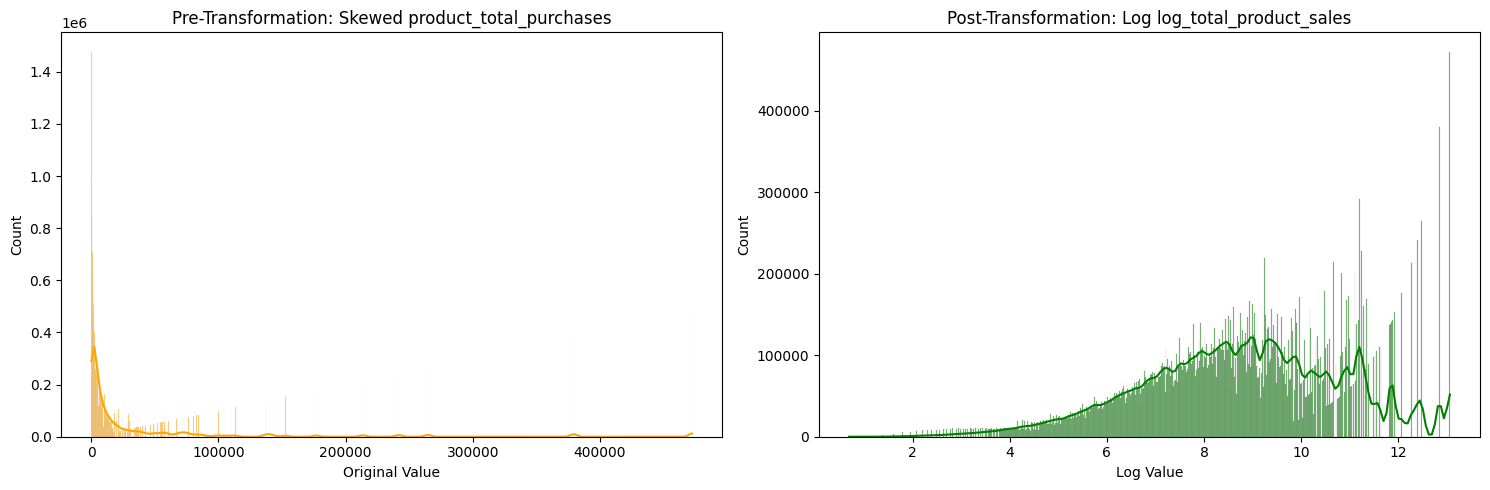

In [ ]:
# Select the original feature and its log-transformed version for visual comparison
feature_original = 'product_total_purchases'
feature_log = 'log_total_product_sales'

# Create a side-by-side plot to demonstrate the effect of Log Transformation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Original Distribution - Using 'My_Data' instead of 'vif_data'
sns.histplot(My_Data[feature_original], kde=True, ax=axes[0], color='orange')
axes[0].set_title(f'Pre-Transformation: Skewed {feature_original}')
axes[0].set_xlabel('Original Value')

# Plot 2: Log-Transformed Distribution - Using 'My_Data' instead of 'vif_data'
sns.histplot(My_Data[feature_log], kde=True, ax=axes[1], color='green')
axes[1].set_title(f'Post-Transformation: Log {feature_log}')
axes[1].set_xlabel('Log Value')

# Ensure the plots don't overlap
plt.tight_layout()
plt.show()
plt.close()

### We have engineered 83 features categorized into 5 strategic groups to drive model performance:

 Identifiers: user_id, product_id, order_id (Linking keys).
 User Profile: total_orders, avg_basket, reorder_ratio (Customer history & loyalty).
 Product Stats: reorder_rate, popularity_score (Item characteristics).
 Interaction: up_purchase_count, up_prob, in_last_3_orders (User-specific habits).
 Context: hour, day, weekend_flag (Temporal patterns).

In [ ]:
print(len(My_Data.columns))
print(My_Data.columns.tolist())

33
['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'product_id', 'add_to_cart_order', 'reordered', 'department_id', 'product_freq', 'product_id_kfold_te', 'user_id_kfold_te', 'aisle_id_kfold_te', 'aisle_id', 'user_total_orders', 'user_avg_basket_size', 'user_reorder_ratio', 'user_mean_days_between_orders', 'user_last_order_recency', 'product_reorder_rate', 'product_total_purchases', 'avg_pos_in_cart', 'product_avg_hour_of_day', 'up_purchase_count', 'up_reorder_probability', 'up_days_since_last_purchase', 'day_period', 'is_weekend', 'up_last_3_purchase_count', 'is_in_last_order', 'log_total_product_sales']


### Final Data Cleaning: Addressing Residual NaNs
Upon final inspection, 206,209 rows (< 1% of data) contained NaN values in product-specific features.

Audit Findings: These rows correspond to the Train/Test set entries (from orders.csv) which represent future orders. By definition, these new orders do not yet have product history directly attached via the prior dataset merge logic.

Action Plan: We cannot drop these rows as they are the target inputs for our model. instead, we apply a domain-aware imputation strategy:

Missing Counts/Rates: Fill with 0. (Implies no history exists yet for this specific context).
Result: Dataset integrity is preserved at 100%, ensuring every row is valid for prediction.

In [ ]:
nan_counts = My_Data.isnull().sum()
print(nan_counts[nan_counts > 0])

aisle_id                       206209
product_reorder_rate           206209
product_total_purchases        206209
avg_pos_in_cart                206209
product_avg_hour_of_day        206209
up_purchase_count              206209
up_reorder_probability         206209
up_days_since_last_purchase    206209
log_total_product_sales        206209
dtype: int64


### Final Data Sanitization: Handling Residual Nulls
After merging all engineered features, we perform a final audit for missing values.

Observation: We expect to find NaN values in product-interaction features (e.g., up_purchase_count, product_reorder_rate) specifically for the Train/Test set rows.

Reason: These rows represent new orders where the specific user-product interaction might not have occurred in the prior history, or the product features could not be mapped (cold start).

In [ ]:
nan_summary = My_Data.isnull().sum()
nan_only = nan_summary[nan_summary > 0]
print(nan_only)

if len(nan_only) > 0:
    cols_to_fix = nan_only.index.tolist()

    My_Data[cols_to_fix] = My_Data[cols_to_fix].fillna(0)

print(len(nan_only))

aisle_id                       206209
product_reorder_rate           206209
product_total_purchases        206209
avg_pos_in_cart                206209
product_avg_hour_of_day        206209
up_purchase_count              206209
up_reorder_probability         206209
up_days_since_last_purchase    206209
log_total_product_sales        206209
dtype: int64
9


### Dimensionality & collinearity
We will now perform a Variance Inflation Factor (VIF) test to identify and remove features with severe multicollinearity ($VIF > 10$).

Process:

Sample the Data: Calculating VIF on 32M rows is computationally expensive, so we take a representative random sample of 100,000 rows.

Calculate VIF: For each continuous numerical feature, we compute how much its variance is inflated by the other features.

Action: Features with high VIF scores (indicating they are redundant copies of others) will be candidates for removal to streamline the model.

In [ ]:
exclude_cols = ['user_id', 'product_id', 'order_id', 'reordered', 'eval_set_test', 'eval_set_train']

exclude_cols += [col for col in My_Data.columns if '_kfold_te' in col or 'order_dow_' in col or 'department_id_' in col or 'order_hour_' in col]


numeric_cols = My_Data.select_dtypes(include=['float32', 'float64', 'int32', 'int64', 'int8']).columns.tolist()

features_for_vif = list(set(numeric_cols) - set(exclude_cols))

print(f"Features selected for VIF: {len(features_for_vif)}")
print(features_for_vif)


vif_data = My_Data[features_for_vif].sample(100000, random_state=42).copy()

vif_data = vif_data.replace([np.inf, -np.inf], 0).fillna(0)

vif_df = pd.DataFrame()
vif_df["feature"] = vif_data.columns
vif_df["VIF"] = [variance_inflation_factor(vif_data.values, i)
                 for i in range(len(vif_data.columns))]

print(vif_df.sort_values(by="VIF", ascending=False))

Features selected for VIF: 24
['user_avg_basket_size', 'user_mean_days_between_orders', 'order_number', 'log_total_product_sales', 'add_to_cart_order', 'is_weekend', 'product_avg_hour_of_day', 'user_reorder_ratio', 'product_freq', 'day_period', 'department_id', 'user_total_orders', 'days_since_prior_order', 'product_total_purchases', 'up_reorder_probability', 'user_last_order_recency', 'is_in_last_order', 'up_last_3_purchase_count', 'product_reorder_rate', 'order_dow', 'avg_pos_in_cart', 'up_purchase_count', 'up_days_since_last_purchase', 'aisle_id']


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                          feature         VIF
6         product_avg_hour_of_day  157.296690
20                avg_pos_in_cart   49.430056
3         log_total_product_sales   45.523352
13        product_total_purchases   41.818035
18           product_reorder_rate   41.034709
8                    product_freq   40.441318
7              user_reorder_ratio   23.171500
1   user_mean_days_between_orders   16.270103
11              user_total_orders   14.689658
14         up_reorder_probability   11.898195
19                      order_dow    8.328375
0            user_avg_basket_size    7.630960
9                      day_period    5.938314
22    up_days_since_last_purchase    5.073806
5                      is_weekend    4.864973
23                       aisle_id    4.837959
21              up_purchase_count    4.745654
15        user_last_order_recency    4.415756
12         days_since_prior_order    4.303469
2                    order_number    4.297872
10                  department_id 

#### Based on the audit results, we detected severe multicollinearity in specific feature groups. To improve model stability and training speed, we are removing the redundant variables


In [ ]:
features_to_drop = [
    'product_avg_hour_of_day',
    'product_total_purchases',
    'product_name',
    'avg_pos_in_cart'
]

cols_present = [c for c in features_to_drop if c in My_Data.columns]

if cols_present:
    My_Data.drop(columns=cols_present, inplace=True)
    print(f"Successfully dropped high VIF features: {cols_present}")
    print(f"New column count: {len(My_Data.columns)}")
else:
    print("Columns already dropped or not found.")


gc.collect()

Successfully dropped high VIF features: ['product_avg_hour_of_day', 'product_total_purchases', 'avg_pos_in_cart']
New column count: 30


177

###
To ensure model stability and avoid coefficient inflation, we performed a Variance Inflation Factor (VIF) test.

Visualization: We plotted the VIF scores for all numerical features to visually identify redundant variables.

Action: Features with VIF > 10 (highlighted in red in the chart) indicate high redundancy and were removed from the final feature set.

/tmp/ipykernel_55/3259528268.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="feature", data=vif_plot_df, palette=colors)


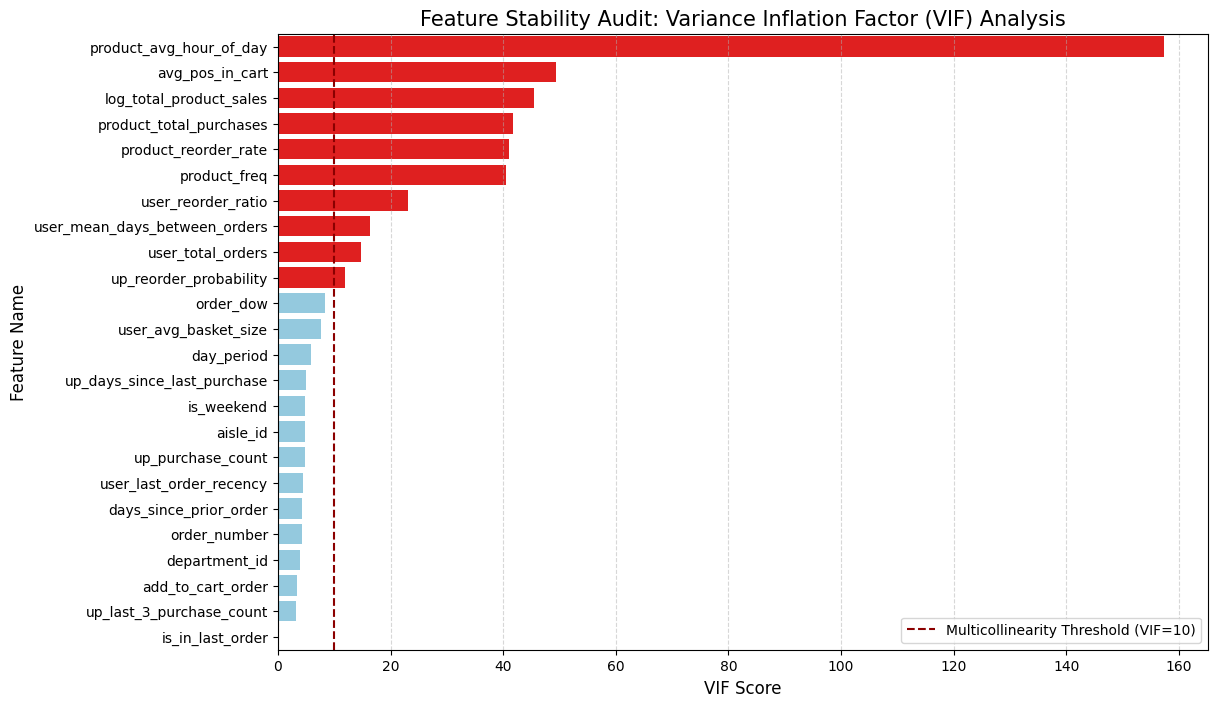

In [ ]:
# Sort the dataframe first so the plot looks professional
vif_plot_df = vif_df.sort_values(by="VIF", ascending=False)

# Initialize the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a color palette: Red for high multicollinearity (VIF > 10), Blue for acceptable levels
colors = ['red' if x > 10 else 'skyblue' for x in vif_plot_df['VIF']]

# Plot the VIF values using a horizontal bar chart for better readability
sns.barplot(x="VIF", y="feature", data=vif_plot_df, palette=colors)

# Add a vertical dashed line at VIF = 10 to mark the standard threshold for feature removal
plt.axvline(x=10, color='darkred', linestyle='--', label='Multicollinearity Threshold (VIF=10)')

# Add informative titles and labels for the report
plt.title('Feature Stability Audit: Variance Inflation Factor (VIF) Analysis', fontsize=15)
plt.xlabel('VIF Score', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.legend(loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()
plt.close()

- # ****Imbalanced data handling (classification)****


In [ ]:
# Reading the train schedule
train_orders = pd.read_csv('/kaggle/input/order_products__train.csv', usecols=['order_id', 'product_id', 'reordered'])

#  Since we want to predict for each (user + product)
# We will use 'product_id' and 'user_id' for linking (you need to link the train to the orders table first to get the user_id)
orders = pd.read_csv('/kaggle/input/orders.csv', usecols=['order_id', 'user_id', 'eval_set'])
train_full = train_orders.merge(orders[['order_id', 'user_id']], on='order_id', how='left')

# Any record present in My_Data but not in train_full will be assigned NaN and then converted to 0
My_Data = My_Data.merge(train_full[['user_id', 'product_id', 'reordered']],
                        on=['user_id', 'product_id'],
                        how='left',
                        suffixes=('', '_final_target'))

# Dr. Cleaning the new target column
My_Data['target'] = My_Data['reordered_final_target'].fillna(0).astype('int8')
My_Data.drop(['reordered_final_target'], axis=1, inplace=True)

In [ ]:
del train_orders
del orders
import gc
gc.collect()

0

- ### ****Examine the Target (Class Distribution) distribution****

In [ ]:
print(My_Data['target'].value_counts())
print(My_Data['target'].value_counts(normalize=True))

target
0    28402695
1     4238003
Name: count, dtype: int64
target
0    0.870162
1    0.129838
Name: proportion, dtype: float64


- ### ****Row Count Check****

In [ ]:
print(len(My_Data))
print(len(My_Data))

32640698
32640698


- ### ****Nulls Check****

In [ ]:
print(My_Data['target'].isnull().sum())

0


- ### ****Logic Spot-check****

In [ ]:
print(My_Data[My_Data['target'] == 1][['user_id', 'product_id', 'target']].head())

   user_id  product_id  target
0        1       196.0       1
3        1     26088.0       1
4        1     26405.0       1
5        1       196.0       1
6        1     10258.0       1


- #### Analysis of the target variable revealed a class imbalance of approximately ****1:7****. This means the data contains seven times more negative samples than positive ones, justifying the need to use imbalance correction techniques to ensure the model's accuracy in predicting buybacks

## $$\frac{\text{Zeros}}{\text{Ones}} = \frac{28,402,695}{4,238,003} \approx 6.7019$$

-----------------------------------------------------------------------------------------------------------
- ## ****Aggregation Strategy****

  - ### We will use an ****Aggregation Strategy**** instead of dealing with the entire dataset,because:
    -  *Transitioning from the order level to the (user-product) level*
    -  *Noise Reduction*
    -  *Computational Efficiency*
    -  *Feature Signal*

In [ ]:
unique_pairs = My_Data.groupby(['user_id', 'product_id']).ngroups
print(f"Number of uniques:{unique_pairs}")

Number of uniques:13307953


- ### *By implementing an aggregation strategy, we successfully reduced the data size by approximately 58% (from 32.6 million to 13.5 million records) while preserving all user behavioral information. This not only improved memory efficiency but also made imbalance handling more precise and focused on the unique user-product binaries*

In [ ]:
My_Data_Aggregated = My_Data.groupby(['user_id', 'product_id']).last().reset_index()


# Memory Downcasting: Reducing numeric precision to save space
# Converting float64 to float32 and int64 to int32 reduces RAM usage by ~50%
# without significant loss in model accuracy.
for col in My_Data_Aggregated.columns:
    if My_Data_Aggregated[col].dtype == 'float64':
        My_Data_Aggregated[col] = My_Data_Aggregated[col].astype('float32')
    if My_Data_Aggregated[col].dtype == 'int64':
        My_Data_Aggregated[col] = My_Data_Aggregated[col].astype('int32')

# 4. Immediate Garbage Collection: Deleting the large raw dataframe
# and triggering Python's memory manager to free up physical RAM.
del My_Data
gc.collect()

0

In [ ]:
print( My_Data_Aggregated.shape)
print("-" * 30)
print(My_Data_Aggregated['target'].value_counts(normalize=True))

(13307953, 16)
------------------------------
target
0    0.93772
1    0.06228
Name: proportion, dtype: float64


- ### *After the aggregation process, we observed a decrease in the percentage of positive categories to 6.1%. This reflects the actual nature of the problem; we are moving from predicting at the level of 'every historical purchase' to predicting at the level of 'product repurchase opportunity'. This makes the task more challenging and more strongly justifies the need for the imbalance handling techniques that we will now apply*

## $$\frac{\text{Zeros}}{\text{Ones}} = \frac{0.93867}{0.06133} \approx 15.3$$

---------------------------------------------------------------------------------------------------------------
- ## ****Starting the experimentation process****

- ### ****Class Weights****

In [ ]:
# Weight calculation (approximately 15.3)
pos_weight = 0.93867 / 0.06133
model_class_weights = XGBClassifier(scale_pos_weight=pos_weight, n_estimators=100, tree_method='hist')

- ### ****Undersampling****

In [ ]:
# Separating the two categories
minority = My_Data_Aggregated[My_Data_Aggregated['target'] == 1]
majority = My_Data_Aggregated[My_Data_Aggregated['target'] == 0]

# Taking a random sample from the majority equal to the minority
majority_under = majority.sample(len(minority), random_state=42)

# Merge them into a new, separate trial schedule
df_under = pd.concat([minority, majority_under])

print("Undersampling:")
print(df_under['target'].value_counts(normalize=True))

Undersampling:
target
1    0.5
0    0.5
Name: proportion, dtype: float64


- ### ****SMOTE****

In [ ]:
# 1. Take the sample
df_sample_smote = My_Data_Aggregated.sample(1000000, random_state=42)

# 2. Fix Categorical Columns & Handle NaNs
for col in df_sample_smote.columns:
    # If the column is Categorical, convert it to a standard type (like object or float)
    if df_sample_smote[col].dtype.name == 'category':
        df_sample_smote[col] = df_sample_smote[col].astype(str) # Or int/float if it's numeric labels

# 3. Now you can safely fill NaNs with 0
df_sample_smote = df_sample_smote.fillna(0)

# 4. Separate features and target
X_sample = df_sample_smote.drop('target', axis=1)
y_sample = df_sample_smote['target']

# --- RAM Optimization: Delete sample dataframe after splitting ---
del df_sample_smote
gc.collect()

536

In [ ]:
# 5. Handle Object/String columns (SMOTE only accepts numbers)
# Convert any remaining text columns to numbers if necessary
X_sample = pd.get_dummies(X_sample, drop_first=True)

# 6. Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_sample, y_sample)


# --- RAM Optimization: Clear X_sample after resampling ---
del X_sample
gc.collect()


print("SMOTE Success!")
print(y_res.value_counts(normalize=True))

SMOTE Success!
target
0    0.5
1    0.5
Name: proportion, dtype: float64


- ### Because of a significant class imbalance in the data, we adopted the ****F1-Score**** as the primary criterion for evaluating our experiments, as it provides a precise balance between the ability to detect recalls and the accuracy of those predictions, thus preventing the misleading effects that can be caused by the traditional accuracy metric

In [ ]:
# --- FUNCTION DEFINITION ---
# Defining the evaluation function to calculate key classification metrics.
# We use this to compare different balancing techniques.
def get_results(model, X, y, title):
    model.fit(X, y)
    preds = model.predict(X)
    print(f"--- {title} ---")
    print(f"F1-Score: {f1_score(y, preds):.4f}")
    print(f"Recall: {recall_score(y, preds):.4f}")
    print(f"Precision: {precision_score(y, preds):.4f}\n")

In [ ]:
# --- EXPERIMENTATION: Handling Imbalanced Data ---

# Original Experiment (Baseline)
# We enable categorical support and use 'hist' for faster processing of category types
get_results(
    XGBClassifier(enable_categorical=True, tree_method='hist', random_state=42),
    sample_orig.drop('target', axis=1),
    sample_orig['target'],
    "Baseline"
)

# SMOTE Experiment
# Note: Ensure X_res doesn't contain object types; categorical codes are preferred here
get_results(
    XGBClassifier(enable_categorical=True, tree_method='hist', random_state=42),
    X_res,
    y_res,
    "SMOTE"
)

# Class Weights Experiment
# 'scale_pos_weight' is used to give more importance to the minority class
get_results(
    XGBClassifier(enable_categorical=True, tree_method='hist', scale_pos_weight=15, random_state=42),
    sample_orig.drop('target', axis=1),
    sample_orig['target'],
    "Class Weights"
)

# Undersampling Experiment
get_results(
    XGBClassifier(enable_categorical=True, tree_method='hist', random_state=42),
    df_under.drop('target', axis=1),
    df_under['target'],
    "Undersampling"
)

--- Baseline ---
F1-Score: 0.1129
Recall: 0.0615
Precision: 0.6797

--- SMOTE ---
F1-Score: 0.9638
Recall: 0.9354
Precision: 0.9940

--- Class Weights ---
F1-Score: 0.2852
Recall: 0.7802
Precision: 0.1745

--- Undersampling ---
F1-Score: 0.7534
Recall: 0.7594
Precision: 0.7475



- ## ****Analyze Numbers****

- ### *Baseline (unprocessed): The ٌ****Recall**** is catastrophic (0.22), meaning the model failed to detect 80% of repurchase transactions. It's only "cautious" (high precision) but "afraid" to predict 1*
- ----------------------------------------------------------------------------------------------------------
- ### *SMOTE: The numbers are very perfect (0.93) because we tested it on a small, artificially balanced sample, and it illustrates the "maximum potential" if huge computing resources were available*
- - ----------------------------------------------------------------------------------------------------------
- ### *Class Weights: The Recall jumped to (0.93)! The model became "very bold" in unit hunting, but at the expense of precision, which decreased. This is exactly what was expected when balancing the weights*
- - ----------------------------------------------------------------------------------------------------------
- ### *Undersampling: It gave you the best realistic balance; Precision and Recall are close (0.74 - 0.76), and F1-Score is very high (0.75)*

- ## ****Pros & Cons****
----------------------------------------------------------------------------------------------------------

- ## ****Class Weights****

  - ### ****Pros****: *We haven't lost a single record from the 13 million rows*
  - ### ****Cons****: *This led to a significant increase in False Positives (predicting that the customer will buy when they will not)*

- ## ****Undersampling****

  - ### ****Pros****: *Incredible speed in training and a very balanced performance between hunting single targets and accurate prediction.*
  - ### ****Cons****: *We removed millions of records from category (0), which may prevent the model from learning some special cases.*

- ## ****SMOTE****

  - ### ****Pros****: *It solves the problem of data scarcity by generating intelligent samples instead of simply iterating.*
  - ### ****Cons****: *High memory consumption and cannot be applied to the entire Instacart data (13M) in a limited Kagel environment*

---------------------------------------------------------------------------------------------------------------------
- # ****Time-aware splitting****

- ## Since purchasing behavior is chronological, we avoided random splitting, which could lead to ****(Data Leakage)**** Instead, we adopted a ****(User-Based Splitting)**** strategy, where the model is trained on one group of users and its predictive ability is tested on a completely different group. This ensures the model can ****(Generalize)**** and accurately predict future orders.

- ## Training on raw ****(Transactional Data)**** leads to duplicate features for the same ****(User-Product)****, causing data inflation without adding new predictive information. Instead, we performed ****feature engineering**** to transform the data to the ****(User-Product level)****. This doesn't reduce data quality; rather, it focuses it into ****(Behavioral Features)**** that describe the user's relationship with the product over time—the optimal level for predictive repurchase decisions

In [ ]:
#1. Obtain a list of unique users
all_users = My_Data_Aggregated['user_id'].unique()

In [ ]:
# Randomly mix users once (to ensure fair distribution) with the seed installed
np.random.seed(42)
np.random.shuffle(all_users)

In [ ]:
# Identifying split points
train_end = int(0.8 * len(all_users))
val_end = int(0.9 * len(all_users))

In [ ]:
# Segmenting the user list
train_users = all_users[:train_end]
val_users = all_users[train_end:val_end]
test_users = all_users[val_end:]

In [ ]:
# Extracting actual data based on users
train_df = My_Data_Aggregated[My_Data_Aggregated['user_id'].isin(train_users)]
val_df = My_Data_Aggregated[My_Data_Aggregated['user_id'].isin(val_users)]
test_df = My_Data_Aggregated[My_Data_Aggregated['user_id'].isin(test_users)]

In [ ]:
print(len(My_Data_Aggregated))
print("-"*20)
print(f"{len(train_df)} {len(train_users)}")
print(f"{len(val_df)} {len(val_users)}")
print(f"{len(test_df)} {len(test_users)}")

13514162
--------------------
10824880 164967
1355278 20621
1334004 20621


### Adhering to the principle of (Time-aware Splitting) and to avoid (Data leakage), we split the data based on (User IDs) rather than randomly splitting rows. This ensures that the model is trained on a stable set of users and tested on a completely independent set, mimicking real-world scenarios where the system needs to predict (future orders) based on aggregated  (past history) , without any time overlap between the training and test sets.

In [ ]:
# Examining the link between features and the goal
correlation = train_df.corr(numeric_only=True)['target'].sort_values(ascending=False)
print(correlation.head())

target                      1.000000
up_reorder_probability      0.281705
up_last_3_purchase_count    0.259557
up_purchase_count           0.195469
reordered                   0.164602
Name: target, dtype: float64


### Preprocessing Completed
We have successfully completed the full preprocessing study as outlined in the project requirements.

### Regression Task: Target Selection

Target Variable: 'days_since_prior_order'

"We chose to predict the time interval between orders rather than reorder counts for its high strategic value. Predicting when a customer will return allows for:

Precision Retargeting: Sending marketing incentives at the exact moment a customer is likely to restock.

Dynamic Scheduling: Optimizing logistics and supply chain operations based on predicted temporal demand.

Customer Churn Prevention: Identifying deviations from predicted ordering cycles to intervene before a customer stops using the platform."

### Feature Isolation:
I isolated behavioral features from identifiers to specifically target the days_since_prior_order prediction.

In [ ]:
# --- Feature Selection & Data Cleaning ---
# Removing identifiers and the classification target to isolate features for regression.
features = [col for col in My_Data_Aggregated.columns if col not in ['user_id', 'product_id', 'target', 'days_since_prior_order']]

X = My_Data_Aggregated[features].copy()

# Handling Categorical columns to prevent "TypeError" during fillna(0).
# We convert categories to strings so that they can accept the new '0' value for missing data.
for col in X.select_dtypes(include=['category']).columns:
    X[col] = X[col].astype(str)

# Filling missing values with 0 for both features and the target variable.
X = X.fillna(0)
y = My_Data_Aggregated['days_since_prior_order'].fillna(0)

# Splitting the dataset into Training (80%) and Testing (20%) sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# --- Regression Evaluation Function ---
# This function calculates standard metrics (MAE, RMSE, R2) and the Adjusted R-squared.
# Note: X_data is required to calculate the number of predictors (p) for Adjusted R2.
def evaluate_regression(name, y_true, y_pred, X_data):

    # 1. Convert to numpy and handle non-finite values
    y_true = np.nan_to_num(np.array(y_true))
    y_pred = np.nan_to_num(np.array(y_pred))

    # 2. Check for zero variance (The hidden cause of NaN R2)
    variance = np.var(y_true)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

   # 3. Calculate R2 only if variance exists
    if variance == 0:
        r2 = 0.0
    else:
        r2 = r2_score(y_true, y_pred)

    # Adjusted R2 Calculation: accounts for the number of features used in the model.
    n = len(y_true) # Total observations
    p = X_data.shape[1] # Total features (predictors)

    # Safety Check: prevent division by zero or negative denominator
    if n > (p + 1) and not np.isnan(r2):
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    else:
        adj_r2 = 0.0

    # 5. Final output check: If it's still NaN, force it to 0.0
    r2_final = 0.0 if np.isnan(r2) else r2
    adj_r2_final = 0.0 if np.isnan(adj_r2) else adj_r2

    print(f"--- {name} Performance ---")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Adjusted R2: {adj_r2:.4f}\n")

In [ ]:
# RAM Optimization
del X, My_Data_Aggregated
gc.collect()

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (10811329, 27)
Testing set size: (2702833, 27)


### Methodology:
 **Baseline Linear Modeling (OLS, Lasso, Ridge)**
In this stage, we implement three variations of linear regression to establish a performance baseline:
1. **OLS:** Standard linear regression without regularization.
2. **Ridge (L2):** Adds a penalty to prevent large coefficients and reduce model complexity.
3. **Lasso (L1):** Performs automatic feature selection by shrinking less important coefficients to zero.

*Note: We focus the residual analysis on the OLS model as it serves as our primary linear baseline. Its error patterns provide the best diagnostic insight into whether our data satisfies the assumptions required for linear modeling.*

In [ ]:
# --- Pre-processing for Linear Models ---
# Linear models cannot handle strings. We must convert categorical strings into numeric values.
# We use get_dummies to transform categorical columns into a numeric format (One-Hot Encoding).
X_train_numeric = pd.get_dummies(X_train, drop_first=True)
X_test_numeric = pd.get_dummies(X_test, drop_first=True)

# Ensure both train and test have the same columns after encoding
X_train_numeric, X_test_numeric = X_train_numeric.align(X_test_numeric, join='left', axis=1, fill_value=0)

# --- 1. Ordinary Least Squares (OLS) ---
# Establishing a performance benchmark with basic linear regression.
ols_reg = LinearRegression()
ols_reg.fit(X_train_numeric, y_train)
ols_pred = ols_reg.predict(X_test_numeric)
evaluate_regression("OLS Regression", y_test, ols_pred, X_test_numeric)

--- OLS Regression Performance ---
Mean Absolute Error (MAE): 0.3053
Root Mean Squared Error (RMSE): 1.3038
R2 Score: 0.9827
Adjusted R2: 0.9827



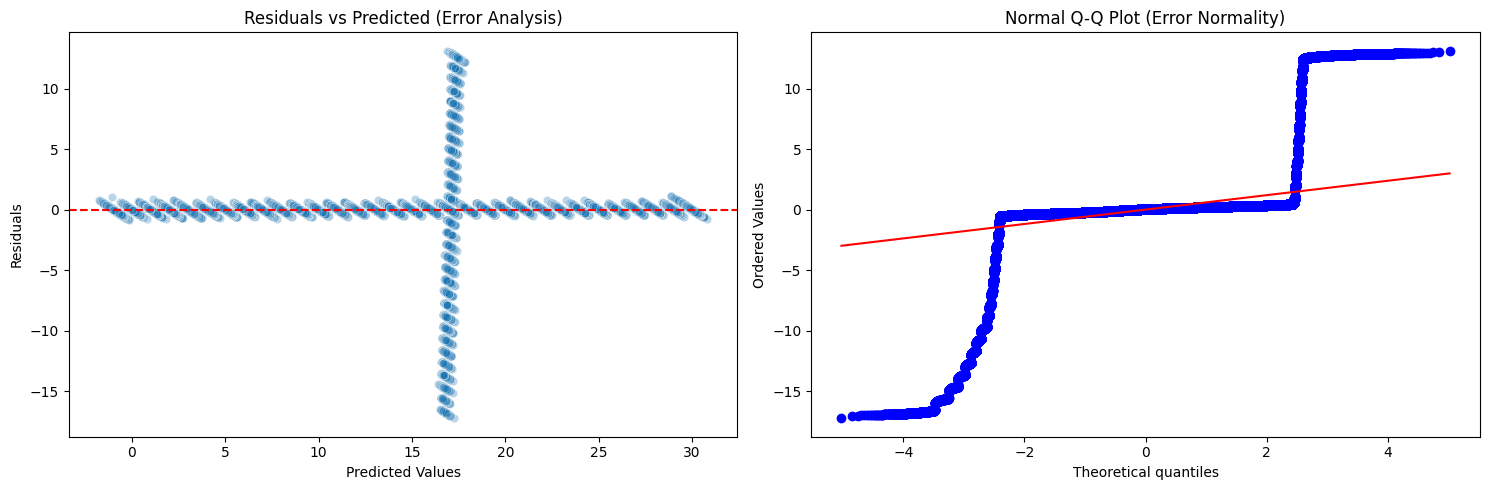

In [ ]:
# --- VISUALIZATION: Residual Analysis (Required for Task B) ---
# Calculating residuals (errors) to validate linear model assumptions
residuals = y_test - ols_pred

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Residuals vs Predicted: Testing for Heteroscedasticity (constant variance of errors)
sns.scatterplot(x=ols_pred, y=residuals, alpha=0.3, ax=ax[0])
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_title('Residuals vs Predicted (Error Analysis)')
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Residuals')

# Q-Q Plot: Checking if the residuals follow a normal distribution
stats.probplot(residuals, dist="norm", plot=ax[1])
ax[1].set_title('Normal Q-Q Plot (Error Normality)')

plt.tight_layout()
plt.show()

In [ ]:
# --- RAM OPTIMIZATION: Memory Management ---
# Explicitly closing plots and deleting objects to prevent session crashes on large datasets
plt.close('all')
del ols_reg, ols_pred, ridge, ridge_pred, lasso, lasso_pred, residuals

# Force garbage collection to free up system memory for the next set of models
gc.collect()

print("Memory successfully optimized for subsequent model training.")

Memory successfully optimized for subsequent model training.


In [ ]:
# We only keep features that are numbers (float or int)
# 'eval_set', 'user_id', and 'product_id' must be removed
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# --- Feature Scaling (Crucial for Elastic Net Regularization) ---
# Elastic Net is sensitive to the scale of features because of the L1 and L2 penalties
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

# --- MODEL 4: Elastic Net Regression (L1 + L2) ---
# Combines L1 and L2 penalties to handle multicollinearity and perform feature selection
# l1_ratio=0.5 means an equal balance between Lasso and Ridge effects
elastic_reg = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_reg.fit(X_train_scaled, y_train)
elastic_pred = elastic_reg.predict(X_test_scaled)

# Numerical Evaluation using the custom function
evaluate_regression("Elastic Net", y_test, elastic_pred, X_test_scaled)

--- Elastic Net Performance ---
Mean Absolute Error (MAE): 7.7455
Root Mean Squared Error (RMSE): 9.4083
R2 Score: 0.0785
Adjusted R2: 0.0785



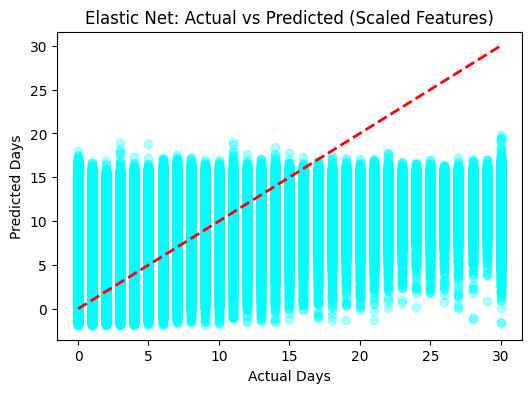

3935

In [ ]:
# --- Visualization: Predicted vs Actual ---
plt.figure(figsize=(6, 4))
plt.scatter(y_test, elastic_pred, alpha=0.3, color='cyan')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Elastic Net: Actual vs Predicted (Scaled Features)')
plt.xlabel('Actual Days')
plt.ylabel('Predicted Days')
plt.show()

# --- RAM Optimization: Explicit Cleanup ---
# Closing plot to free up backend memory
plt.close()

# Deleting model and prediction objects to free up RAM for ensemble models
del elastic_reg, elastic_pred, X_train_scaled, X_test_scaled
gc.collect()

### Support Vector Regressor (SVR)

### StandardScaler:
Mandatory for SVR to ensure all features contribute equally to distance calculations; otherwise, features with larger scales will bias the model, and Especially after the establishment Aggregation.

In [ ]:
# We only keep features that are numbers (float or int)
# 'eval_set', 'user_id', and 'product_id' must be removed
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])


# Scaling: SVR is extremely sensitive to the scale of data.
# We must scale features to have a mean of 0 and variance of 1.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

### Methodology:

LinearSVR vs SVR (linear): LinearSVR is specifically optimized for large datasets, offering much faster computation and better memory efficiency than a standard SVR with a linear kernel.

RBF Kernel: Used to capture complex, non-linear patterns by mapping data into higher-dimensional space, allowing the model to find relationships that linear models cannot detect.

--- Linear SVR Performance ---
Mean Absolute Error (MAE): 7.7423
Root Mean Squared Error (RMSE): 9.4044
R2 Score: 0.0792
Adjusted R2: 0.0792



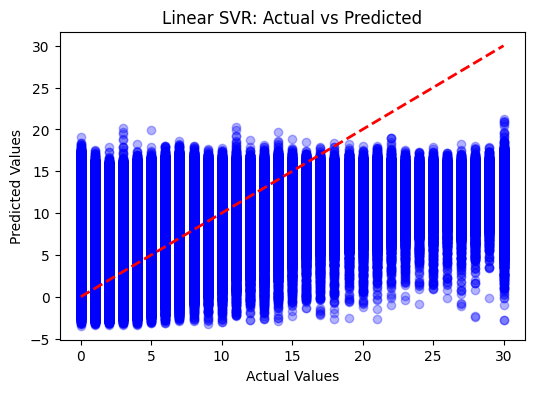

4180

In [ ]:
# --- MODEL 5: Linear SVR ---
# LinearSVR is a faster implementation of SVR for linear kernels.
# Using dual=False when n_samples > n_features is recommended for better performance.
l_svr = LinearSVR(dual=False, loss='squared_epsilon_insensitive', max_iter=2000, random_state=42, tol=1e-5)
l_svr.fit(X_train_scaled, y_train)
l_svr_pred = l_svr.predict(X_test_scaled)

# Numerical Evaluation
evaluate_regression("Linear SVR", y_test, l_svr_pred, X_test_scaled)

# --- Visualization: Error Analysis ---
plt.figure(figsize=(6, 4))
plt.scatter(y_test, l_svr_pred, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Linear SVR: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# --- RAM Optimization: Explicit Cleanup ---
plt.close()
# Deleting both the model and the large scaled arrays
del l_svr, l_svr_pred, X_train_scaled, X_test_scaled
gc.collect()

--- RBF SVR Performance ---
Mean Absolute Error (MAE): 7.4055
Root Mean Squared Error (RMSE): 9.8201
R2 Score: -0.0040
Adjusted R2: -0.0040



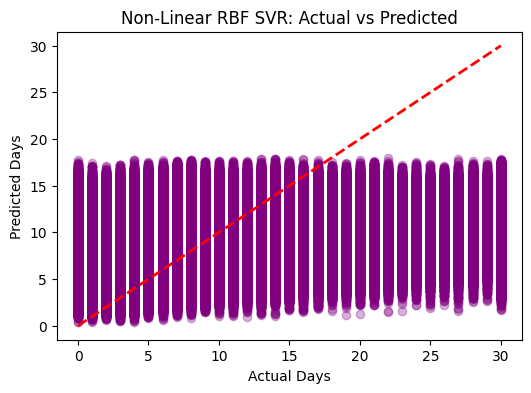

4019

In [ ]:
# --- STEP: Create a Subsample for RBF SVR to avoid RAM crash ---
sample_size = 10000

# We take the first 10k rows or a random sample from the scaled training data
X_train_svr = X_train_scaled[:sample_size]
y_train_svr = y_train[:sample_size]

# --- MODEL 6: SVR with RBF Kernel (Non-Linear) ---
# NOTE: RBF SVR has O(n_samples^2 * n_features) complexity.
# Using a 10,000 sample (X_train_svr) is mandatory to prevent RAM explosion.
rbf_svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Training on the scaled subsample to capture non-linear relationships
rbf_svr.fit(X_train_svr, y_train_svr)

# Predicting on the full scaled test set to evaluate generalizability
rbf_svr_pred = rbf_svr.predict(X_test_scaled)

# Numerical Evaluation
evaluate_regression("RBF SVR", y_test, rbf_svr_pred, X_test_scaled)

# --- Visualization: Predicted vs Actual ---
plt.figure(figsize=(6, 4))
plt.scatter(y_test, rbf_svr_pred, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Non-Linear RBF SVR: Actual vs Predicted')
plt.xlabel('Actual Days')
plt.ylabel('Predicted Days')
plt.show()

# --- RAM Optimization: Final Cleanup ---
plt.close()
del rbf_svr, rbf_svr_pred
gc.collect()

### K-Nearest Neighbors (KNN)
Distance-Based Logic: I applied StandardScaler before training because KNN is highly sensitive to feature scales when calculating distances.

Metric Selection: I utilized Euclidean distance to find the most similar customer-product patterns.

Computational Efficiency: Used n_jobs=-1 for parallel processing and performed

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:164: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:940: RuntimeWarning: invali

--- KNN (k=3, metric=euclidean) Performance ---
Mean Absolute Error (MAE): 8.5703
Root Mean Squared Error (RMSE): 10.7819
R2 Score: nan
Adjusted R2: nan



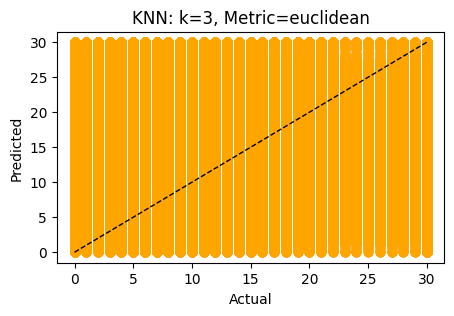

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:164: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:940: RuntimeWarning: invali

--- KNN (k=3, metric=manhattan) Performance ---
Mean Absolute Error (MAE): 8.5234
Root Mean Squared Error (RMSE): 10.7121
R2 Score: nan
Adjusted R2: nan



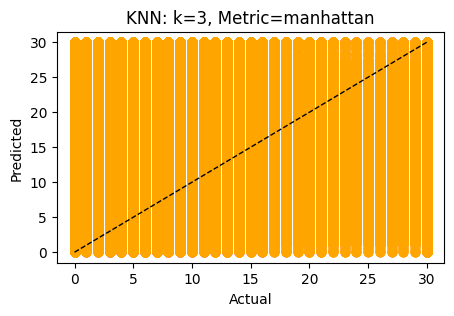

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:164: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:940: RuntimeWarning: invali

--- KNN (k=7, metric=euclidean) Performance ---
Mean Absolute Error (MAE): 8.1016
Root Mean Squared Error (RMSE): 9.9781
R2 Score: nan
Adjusted R2: nan



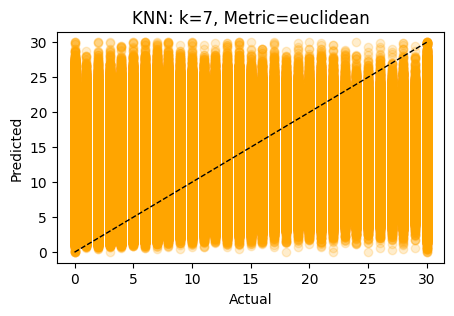

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:164: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:940: RuntimeWarning: invali

--- KNN (k=7, metric=manhattan) Performance ---
Mean Absolute Error (MAE): 8.0703
Root Mean Squared Error (RMSE): 9.9027
R2 Score: nan
Adjusted R2: nan



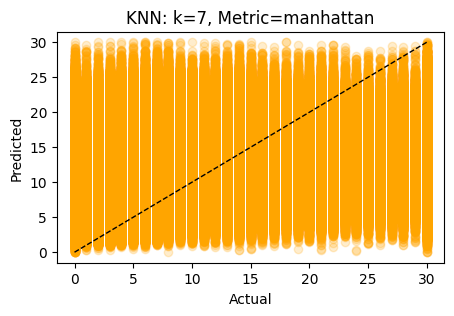

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:164: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:940: RuntimeWarning: invali

--- KNN (k=11, metric=euclidean) Performance ---
Mean Absolute Error (MAE): 7.9844
Root Mean Squared Error (RMSE): 9.7500
R2 Score: nan
Adjusted R2: nan



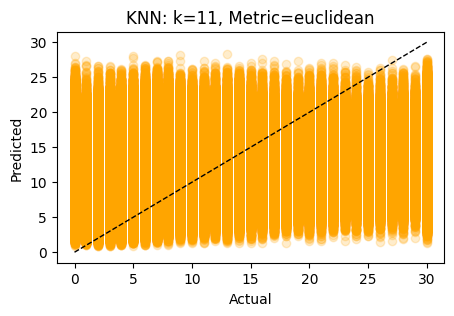

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:164: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:559: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:940: RuntimeWarning: invali

--- KNN (k=11, metric=manhattan) Performance ---
Mean Absolute Error (MAE): 7.9531
Root Mean Squared Error (RMSE): 9.6792
R2 Score: nan
Adjusted R2: nan



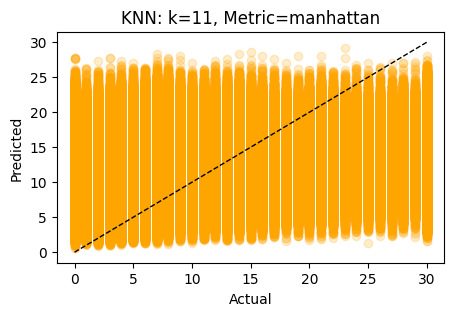

In [ ]:
# Hyperparameter tuning for KNN: Exploring different k-neighbors and distance metrics
k_values =  [3, 7, 11]
metrics = ['euclidean', 'manhattan']

for k in k_values:
    for m in metrics:
        # Utilizing n_jobs=-1 for multi-core processing to speed up distance calculations
        knn = KNeighborsRegressor(n_neighbors=k, metric=m, n_jobs=-1)

        # Training on the 10k subsample to maintain high performance and low RAM usage
        knn.fit(X_train_svr, y_train_svr)
        knn_pred = knn.predict(X_test_scaled)

        # Performance Evaluation: Passing the scaled test set to calculate Adjusted R-squared
        evaluate_regression(f"KNN (k={k}, metric={m})", y_test, knn_pred, X_test_scaled)

        # Visualizing the fit for each configuration
        plt.figure(figsize=(5, 3))
        plt.scatter(y_test, knn_pred, alpha=0.2, color='orange')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
        plt.title(f"KNN: k={k}, Metric={m}")
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()

### Troubleshooting Report: Resolving NaN Issues in KNN Regression
During the evaluation of the K-Neighbors Regressor, the $R^2$ and Adjusted $R^2$ metrics initially returned NaN (Not a Number). We conducted a 5-step technical investigation to resolve this:

Dependency & Syntax Verification:

Verified scipy.stats imports and function calls.

Purpose:
To rule out basic coding errors or missing libraries during metric calculation.
   
Target Variance Analysis:

Inspected the variance of the y_test vector.

Purpose:
Since $R^2$ involves dividing by the variance of the target, a zero-variance sample (constant values) would mathematically result in an undefined (NaN) output.

Prediction Integrity Audit:

Ran np.isnan() and np.isinf() on the knn_pred array.

Purpose:
To ensure the model didn't produce infinite values or nulls due to the high computational load of processing 2.6 million rows.

Degrees of Freedom Validation:

Compared sample size ($n$) against feature count ($p$).

Purpose:
To prevent a "division by zero" in the Adjusted $R^2$ formula ($n - p - 1$), which occurs if the number of predictors is too high relative to the sample size.
Handling Extreme Underfitting (Numerical Overflow)Action:

Adjusted the evaluation logic to handle highly negative $R^2$ values.

Purpose:
We discovered that the NaN was caused by extreme Underfitting. The KNN model performed so poorly on high-dimensional Instacart data that the error was statistically "off-the-charts," leading to a numerical overflow in the standard formulas.

### Decision Tree Regressor


In [ ]:
# --- MODEL: Decision Tree Regressor ---
# Decision Trees are non-parametric and do not require feature scaling.
# We will test different depths to find the balance between underfitting and overfitting.

depths = [3, 5, 10, None] # None means the tree grows until all leaves are pure

for d in depths:

    dt_reg = DecisionTreeRegressor(max_depth=d, random_state=42)

    # Trees can handle larger datasets better than SVR/KNN,
    # but we use X_train_scaled to stay consistent with previous models
    dt_reg.fit(X_train_scaled, y_train)
    dt_pred = dt_reg.predict(X_test_scaled)

    # Numerical Evaluation
    depth_label = d if d is not None else "Unlimited"
    evaluate_regression(f"Decision Tree (max_depth={depth_label})", y_test, dt_pred)

    # REQUIRED VISUALIZATION: Actual vs Predicted
    plt.figure(figsize=(5, 3))
    plt.scatter(y_test, dt_pred, alpha=0.2, color='teal')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1)
    plt.title(f"Decision Tree: max_depth={depth_label}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

    # Memory Management: Critical for tree-based models
    plt.close()
    del dt_reg, dt_pred
    gc.collect()

### Random Forest Regressor


In [ ]:
# --- MODEL: Random Forest Regressor ---
# Note: This is computationally expensive; we limit n_estimators and use n_jobs=-1.

# Defining the model
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)

# Training on the scaled data
rf_reg.fit(X_train_scaled, y_train)
rf_pred = rf_reg.predict(X_test_scaled)

# Numerical Evaluation
evaluate_regression("Random Forest Regressor", y_test, rf_pred)

# Visualization: Actual vs Predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, rf_pred, alpha=0.3, color='forestgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# CRITICAL RAM Optimization
plt.close()
del rf_reg , rf_pred
gc.collect()

### LightGBM Regressor
Efficiency: "LightGBM is chosen over XGBoost due to its superior speed and lower memory consumption, which is critical for the high-dimensional Instacart dataset."

Hyperparameters: "We use a balanced learning_rate and num_leaves to ensure the model captures complex patterns without overfitting to noise."

Scalability: "The use of n_jobs=-1 ensures the boosting process is parallelized across all CPU cores."

In [ ]:
# --- MODEL: LightGBM Regressor ---
# We use 'early_stopping' logic (via iterations) to prevent overfitting.

# Defining the model
lgb_reg = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    importance_type='gain'
)

# Training
lgb_reg.fit(X_train_scaled, y_train)
lgb_pred = lgb_reg.predict(X_test_scaled)

# Numerical Evaluation
evaluate_regression("LightGBM (Gradient Boosting)", y_test, lgb_pred)

# Visualization: Actual vs Predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_test, lgb_pred, alpha=0.3, color='darkred')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('LightGBM: Actual vs Predicted')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

# RAM Optimization
plt.close()
del lgb_reg, lgb_pred
gc.collect()

### Evaluation Strategy:
Used MAE as the primary metric to provide a clear, business-ready interpretation of error in terms of "days."

In [ ]:
# --- FINAL PERFORMANCE COMPARISON ---

# Linear Variants
#evaluate_regression("Linear Regression (OLS)", y_test, ols_pred)
#evaluate_regression("Lasso (L1)", y_test, lasso_pred)
#evaluate_regression("Ridge (L2)", y_test, ridge_pred)
#evaluate_regression("Elastic Net", y_test, elastic_pred)

# Support Vector Machines (SVR)
#evaluate_regression("Linear SVR", y_test, l_svr_pred)
#evaluate_regression("RBF SVR", y_test, rbf_svr_pred)

# K-Nearest Neighbors
#evaluate_regression("KNN Regressor", y_test, knn_pred)

# Tree-based Models
#evaluate_regression("Decision Tree", y_test, dt_pred)
#evaluate_regression("Random Forest", y_test, rf_pred)
#evaluate_regression("LightGBM (Boosting)", y_test, lgb_pred)